<a href="https://colab.research.google.com/github/Ekarpova/Project_Find_My_Dress/blob/main/EKarpova_Siamese_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!git clone https://github.com/Ekarpova/Project_Find_My_Dress.git

fatal: destination path 'Project_Find_My_Dress' already exists and is not an empty directory.


In [3]:
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [4]:
! [ -e /content ] && pip install -Uqq fastai

     |████████████████████████████████| 189 kB 5.3 MB/s 
     |████████████████████████████████| 56 kB 4.5 MB/s 


In [5]:
from fastai.data.external import untar_data,URLs
from fastai.data.transforms import get_image_files
from fastai.vision.all import *
import PIL
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.axes_grid1 import ImageGrid

In [6]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [7]:
def rgb_display(path1, path2):
    image1 = mpimg.imread(path1)
    image2 = mpimg.imread(path2)
    
    plt.axis("off")
    #fig = plt.figure(figsize=(4., 4.))
    fig = plt.figure(figsize=[20, 20])
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 2),  # creates 2x2 grid of axes
                 axes_pad=0,  # pad between axes in inch.
                 )
     
    for ax, im in zip(grid, [image1, image2]):
        # Iterating over the grid returns the Axes.
        ax.imshow(im)


    return plt.show()

In [8]:
class Config():
    
   
    training_dir = "/content/Project_Find_My_Dress/data/train"
    eval_dir = "/content/Project_Find_My_Dress/data/eval_data"
    anchor_folder = "/content/Project_Find_My_Dress/data/original"
    test_folder = "/content/Project_Find_My_Dress/data/test"
    
    train_batch_size = 64
    train_number_epochs = 100

In [66]:
def label_func(fname):
    return re.match(r'^(.*)_\d+.jpg$', fname.name).groups()[0]


In [10]:
files_anchor = get_image_files(Config.anchor_folder)
files_anchor[5]

Path('/content/Project_Find_My_Dress/data/original/short_7.jpg')

In [11]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            while True:
                #keep looping till a different class image is found
                
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] !=img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32)),img0_tuple[0],img1_tuple[0]
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [12]:
folder_dataset = dset.ImageFolder(root=Config.training_dir)

In [13]:
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

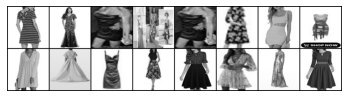

[[0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]]


In [14]:
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

In [15]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

DEFINING CONTRASTIVE LOSS

In [16]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

TRAINING STARTS **HERE** 

In [17]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=Config.train_batch_size)

In [18]:
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0005 )

In [19]:
def train():
    counter = []
    loss_history = [] 
    iteration_number= 0
    for epoch in range(0,Config.train_number_epochs):
        for i, data in enumerate(train_dataloader,0):
            img0, img1 , label,_,_ = data
            img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
            optimizer.zero_grad()
            output1,output2 = net(img0,img1)
            loss_contrastive = criterion(output1,output2,label)
            loss_contrastive.backward()
            optimizer.step()
            if i %10 == 0 :
                print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
                iteration_number +=10
                counter.append(iteration_number)
                loss_history.append(loss_contrastive.item())
                show_plot(counter,loss_history)
    return net

Epoch number 0
 Current loss 1.4447627067565918



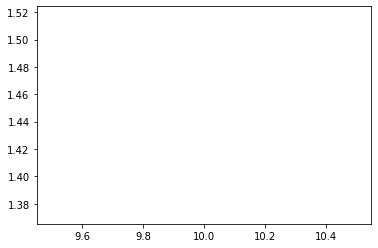

Epoch number 1
 Current loss 79.0194091796875



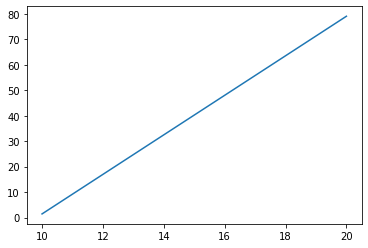

Epoch number 2
 Current loss 46.6563720703125



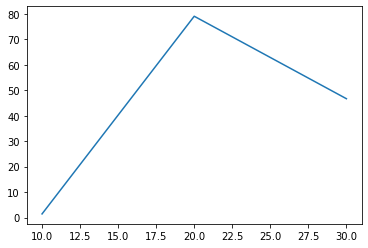

Epoch number 3
 Current loss 44.003135681152344



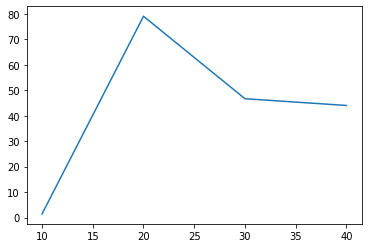

Epoch number 4
 Current loss 15.869458198547363



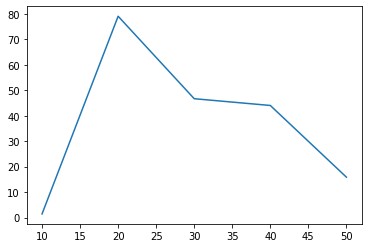

Epoch number 5
 Current loss 12.846052169799805



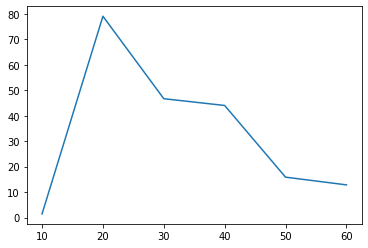

Epoch number 6
 Current loss 13.08397102355957



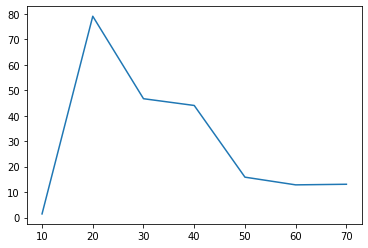

Epoch number 7
 Current loss 16.941532135009766



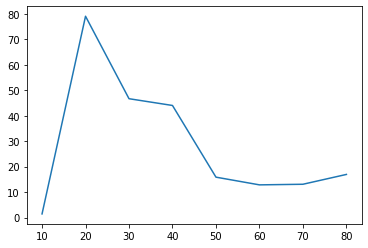

Epoch number 8
 Current loss 9.602058410644531



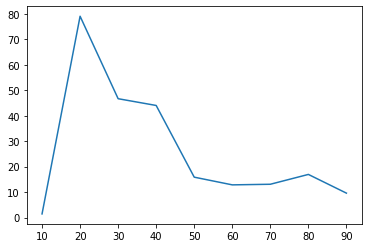

Epoch number 9
 Current loss 12.270910263061523



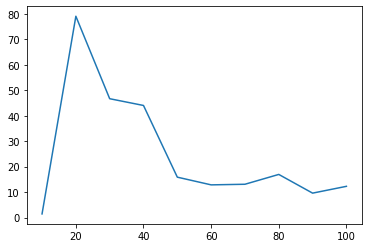

Epoch number 10
 Current loss 8.975988388061523



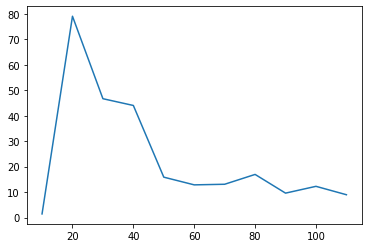

Epoch number 11
 Current loss 5.133057594299316



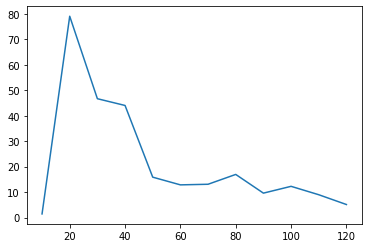

Epoch number 12
 Current loss 9.950994491577148



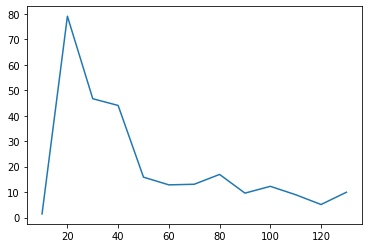

Epoch number 13
 Current loss 7.541594505310059



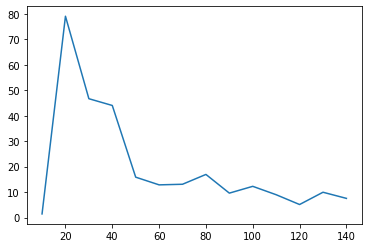

Epoch number 14
 Current loss 4.585875988006592



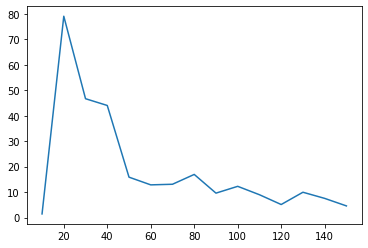

Epoch number 15
 Current loss 5.263297080993652



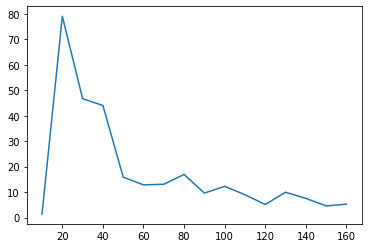

Epoch number 16
 Current loss 4.683506011962891



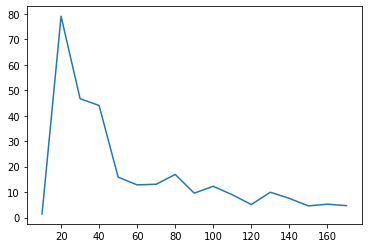

Epoch number 17
 Current loss 3.710103988647461



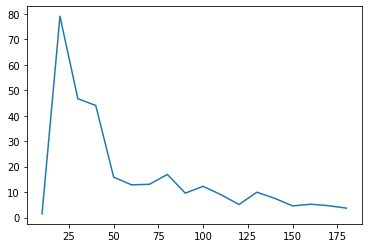

Epoch number 18
 Current loss 3.8261191844940186



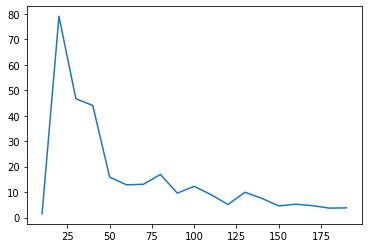

Epoch number 19
 Current loss 2.73809814453125



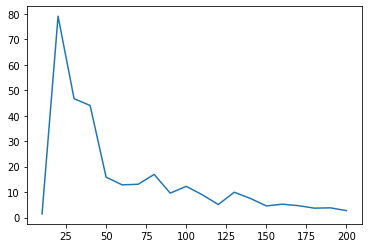

Epoch number 20
 Current loss 3.3346357345581055



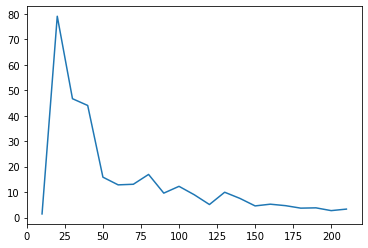

Epoch number 21
 Current loss 2.0561325550079346



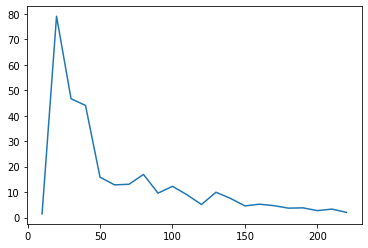

Epoch number 22
 Current loss 4.5887861251831055



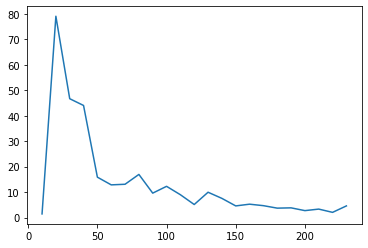

Epoch number 23
 Current loss 2.3698456287384033



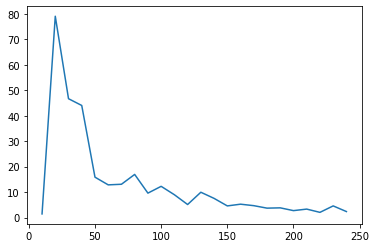

Epoch number 24
 Current loss 5.291808605194092



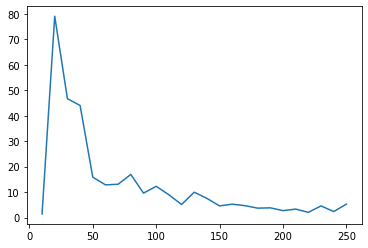

Epoch number 25
 Current loss 6.4600300788879395



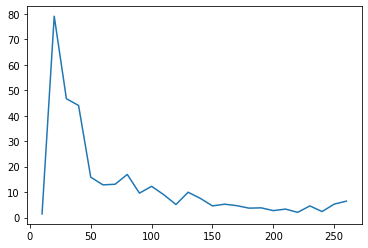

Epoch number 26
 Current loss 6.391777515411377



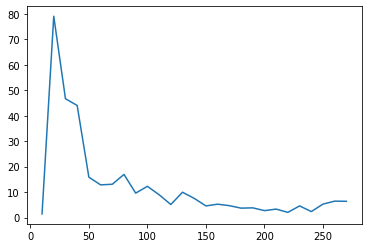

Epoch number 27
 Current loss 5.510863304138184



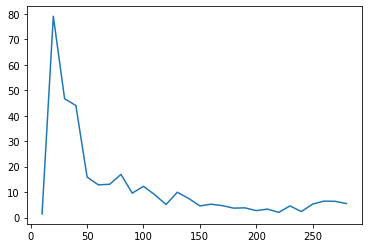

Epoch number 28
 Current loss 4.570618629455566



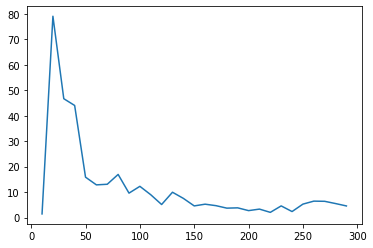

Epoch number 29
 Current loss 3.7903034687042236



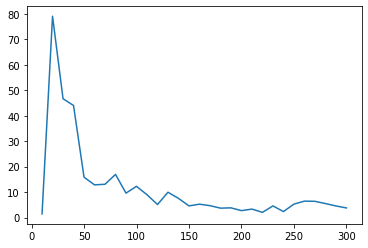

Epoch number 30
 Current loss 1.6202750205993652



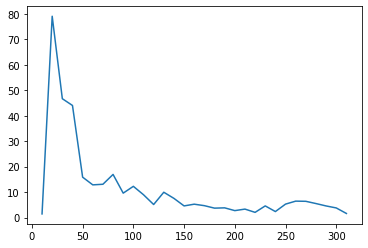

Epoch number 31
 Current loss 3.7018918991088867



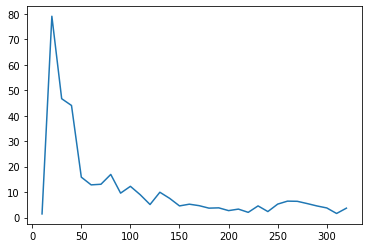

Epoch number 32
 Current loss 3.2536211013793945



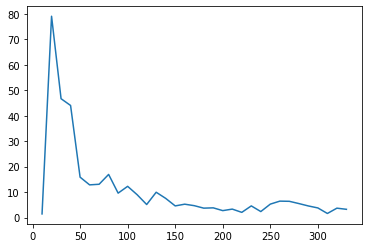

Epoch number 33
 Current loss 3.795368194580078



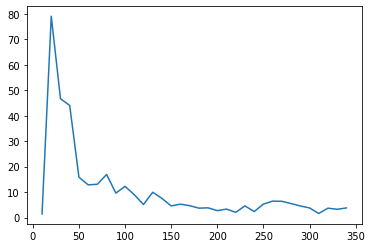

Epoch number 34
 Current loss 3.765353202819824



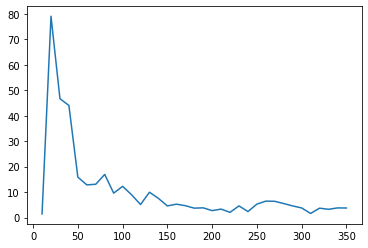

Epoch number 35
 Current loss 3.508023262023926



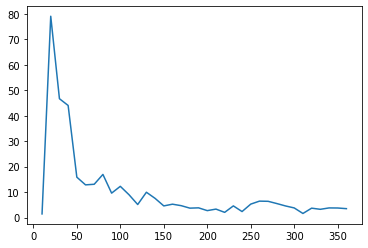

Epoch number 36
 Current loss 3.0945136547088623



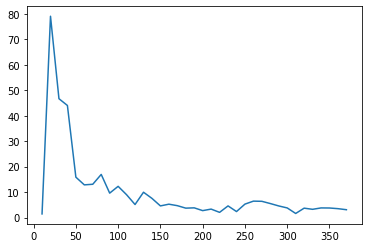

Epoch number 37
 Current loss 2.811617136001587



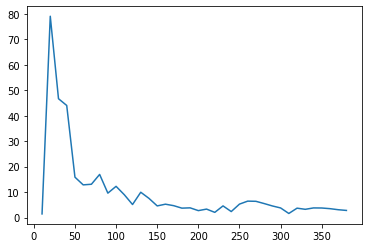

Epoch number 38
 Current loss 2.8557345867156982



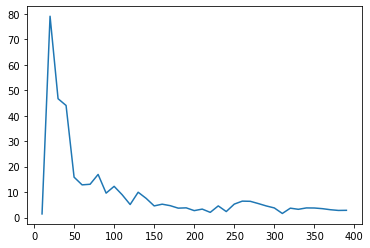

Epoch number 39
 Current loss 1.0996698141098022



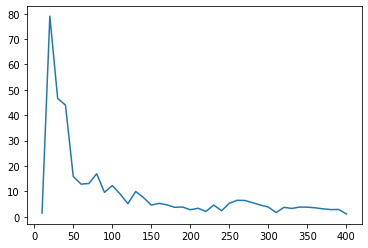

Epoch number 40
 Current loss 2.933004856109619



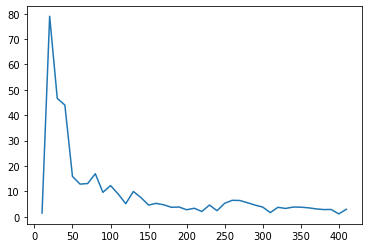

Epoch number 41
 Current loss 1.6466319561004639



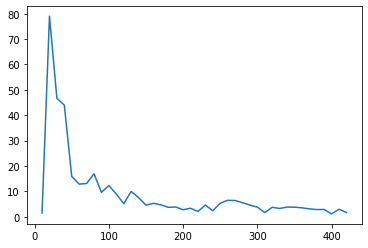

Epoch number 42
 Current loss 1.6009870767593384



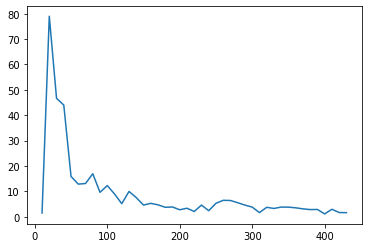

Epoch number 43
 Current loss 1.986527919769287



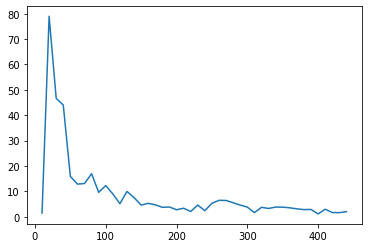

Epoch number 44
 Current loss 1.3348004817962646



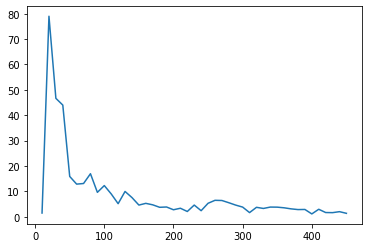

Epoch number 45
 Current loss 2.317697525024414



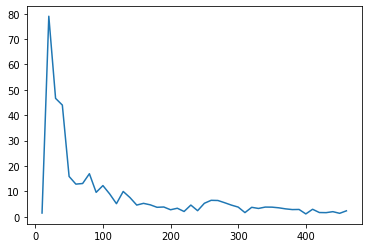

Epoch number 46
 Current loss 1.605059027671814



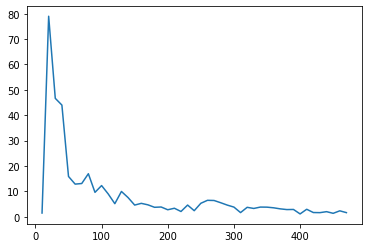

Epoch number 47
 Current loss 1.3934788703918457



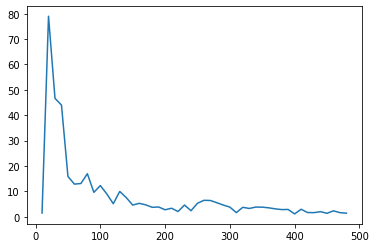

Epoch number 48
 Current loss 1.537258267402649



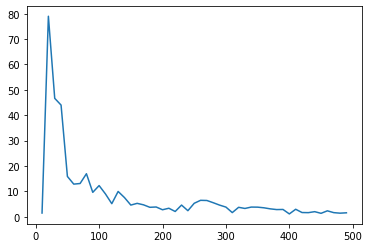

Epoch number 49
 Current loss 1.2140660285949707



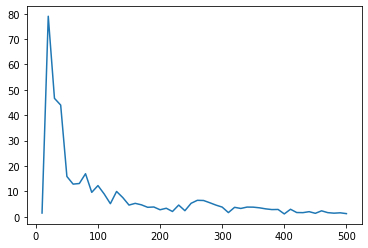

Epoch number 50
 Current loss 0.5790150165557861



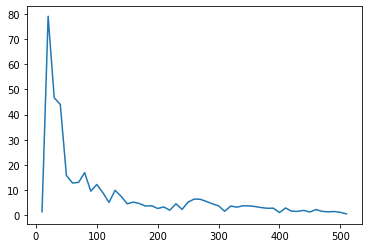

Epoch number 51
 Current loss 2.577746868133545



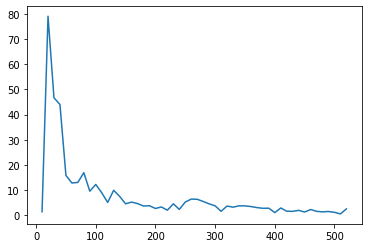

Epoch number 52
 Current loss 1.1211931705474854



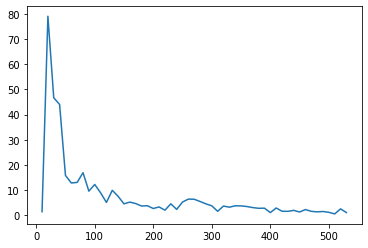

Epoch number 53
 Current loss 1.1107250452041626



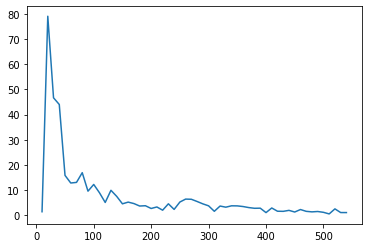

Epoch number 54
 Current loss 1.11808443069458



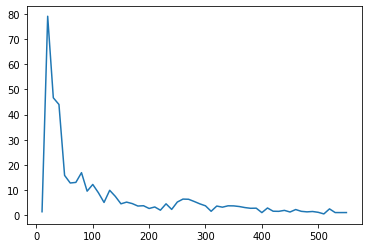

Epoch number 55
 Current loss 1.4473471641540527



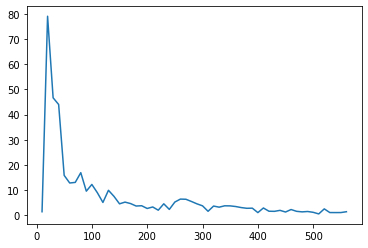

Epoch number 56
 Current loss 1.3783327341079712



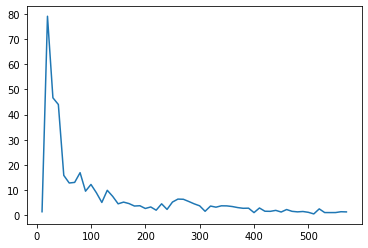

Epoch number 57
 Current loss 1.7212669849395752



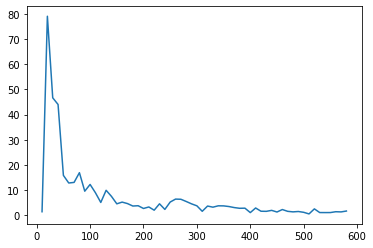

Epoch number 58
 Current loss 0.7481974959373474



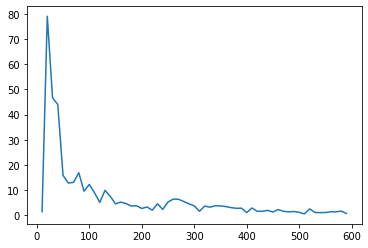

Epoch number 59
 Current loss 1.1478737592697144



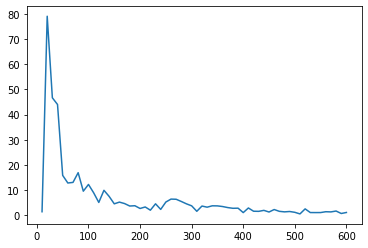

Epoch number 60
 Current loss 0.5377402305603027



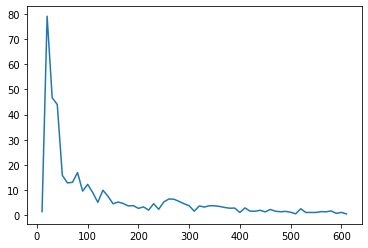

Epoch number 61
 Current loss 0.5265167355537415



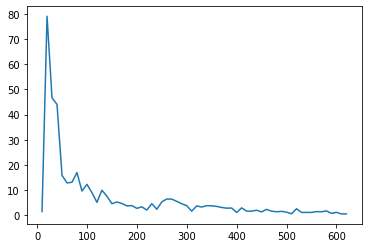

Epoch number 62
 Current loss 1.1760139465332031



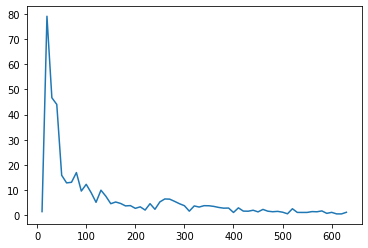

Epoch number 63
 Current loss 0.6769734025001526



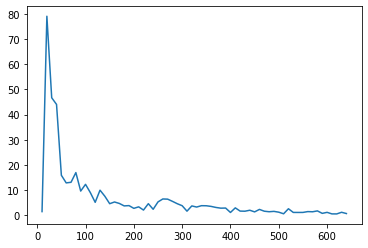

Epoch number 64
 Current loss 0.6910279989242554



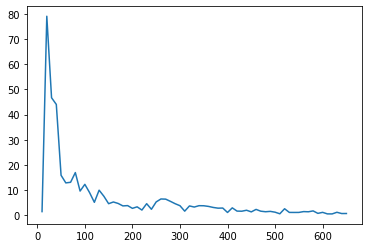

Epoch number 65
 Current loss 1.2068461179733276



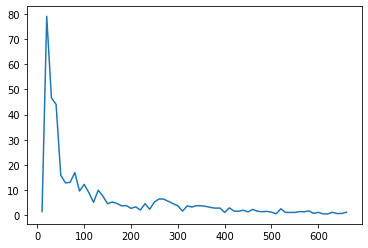

Epoch number 66
 Current loss 0.7773075103759766



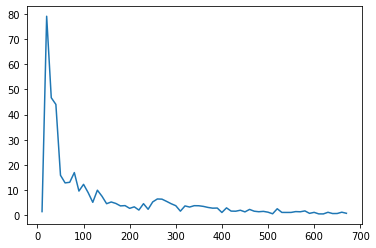

Epoch number 67
 Current loss 0.7802691459655762



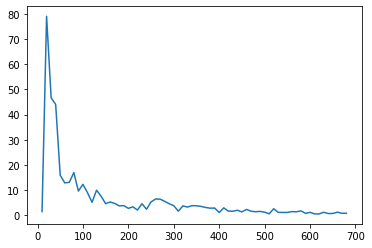

Epoch number 68
 Current loss 0.5361626148223877



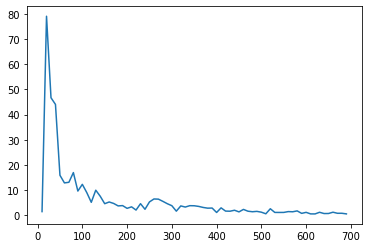

Epoch number 69
 Current loss 0.8099437355995178



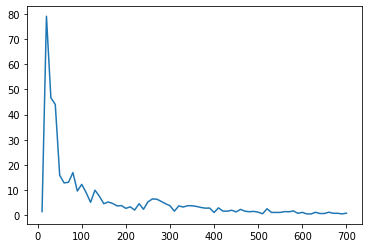

Epoch number 70
 Current loss 0.9041867256164551



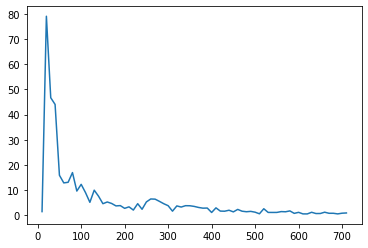

Epoch number 71
 Current loss 0.5141540765762329



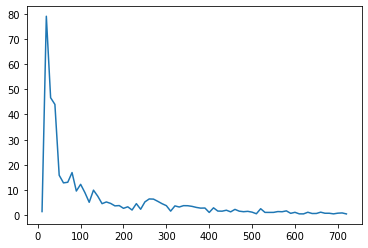

Epoch number 72
 Current loss 0.6635313034057617



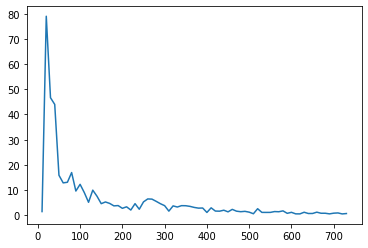

Epoch number 73
 Current loss 0.8294243216514587



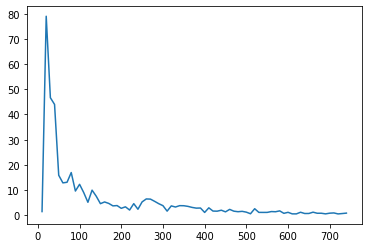

Epoch number 74
 Current loss 0.4729539155960083



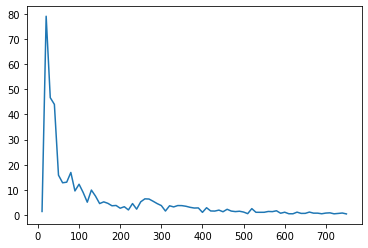

Epoch number 75
 Current loss 0.40843915939331055



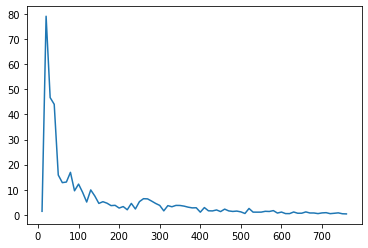

Epoch number 76
 Current loss 0.5160050988197327



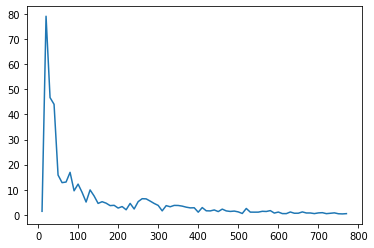

Epoch number 77
 Current loss 0.44498395919799805



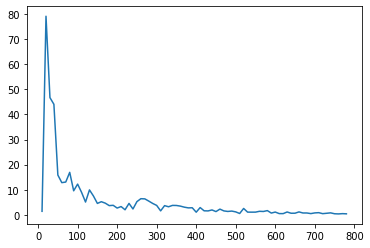

Epoch number 78
 Current loss 0.33468616008758545



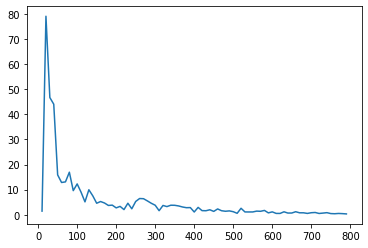

Epoch number 79
 Current loss 0.4933133125305176



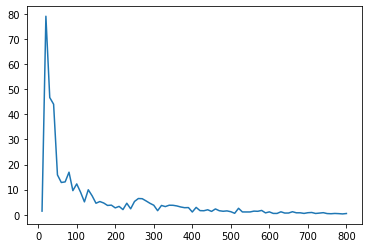

Epoch number 80
 Current loss 0.4229462444782257



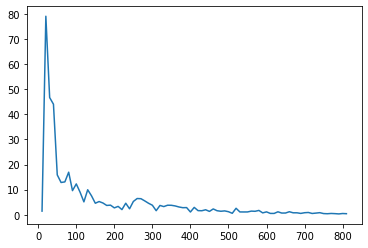

Epoch number 81
 Current loss 0.3855554461479187



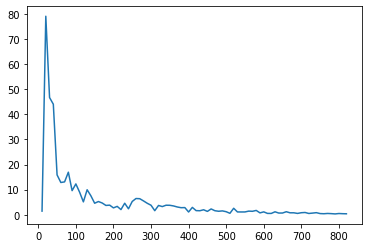

Epoch number 82
 Current loss 0.705489456653595



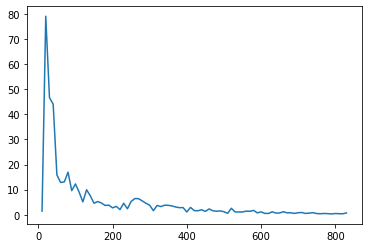

Epoch number 83
 Current loss 0.5779770016670227



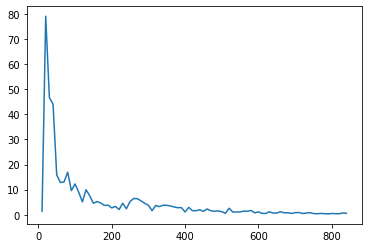

Epoch number 84
 Current loss 0.4354220926761627



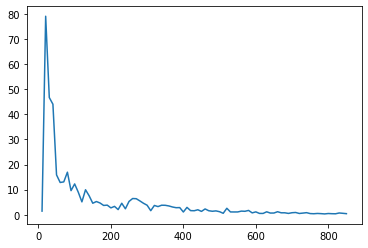

Epoch number 85
 Current loss 0.3762185871601105



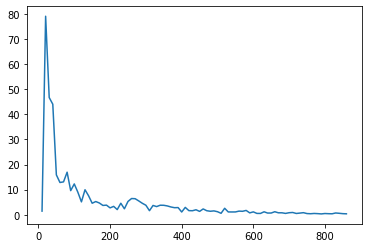

Epoch number 86
 Current loss 0.342358261346817



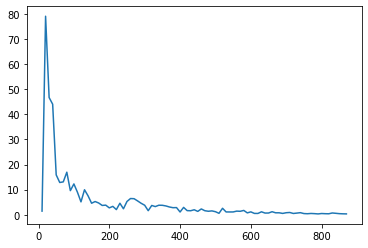

Epoch number 87
 Current loss 0.3939831852912903



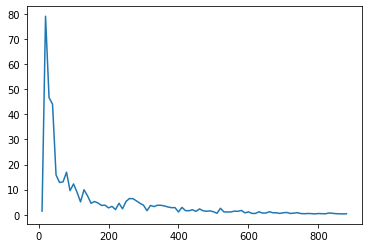

Epoch number 88
 Current loss 0.37275415658950806



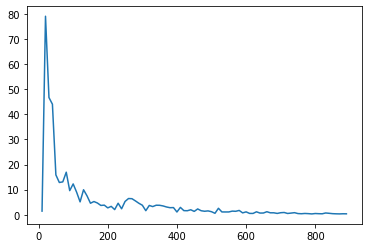

Epoch number 89
 Current loss 0.35977983474731445



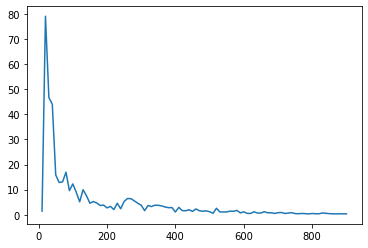

Epoch number 90
 Current loss 0.2401113510131836



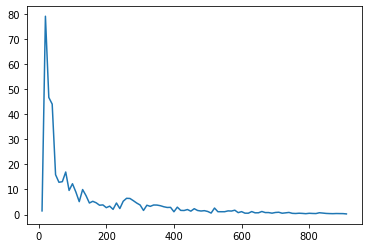

Epoch number 91
 Current loss 0.3284299373626709



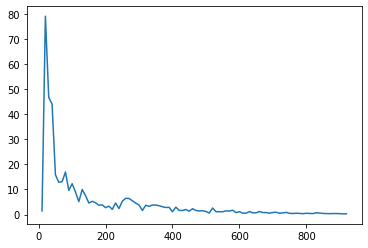

Epoch number 92
 Current loss 0.16638442873954773



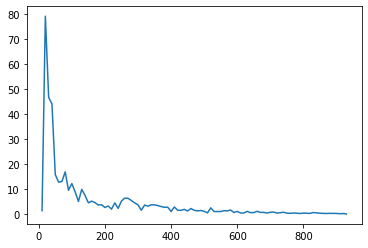

Epoch number 93
 Current loss 0.5155991315841675



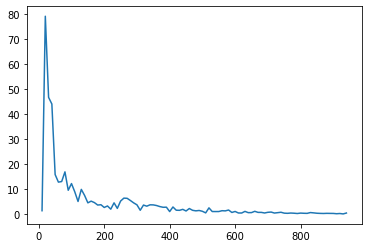

Epoch number 94
 Current loss 0.31969499588012695



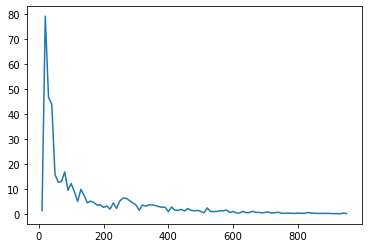

Epoch number 95
 Current loss 0.2876640558242798



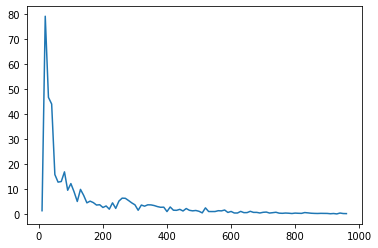

Epoch number 96
 Current loss 0.14929068088531494



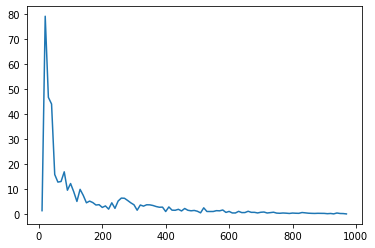

Epoch number 97
 Current loss 0.2500631809234619



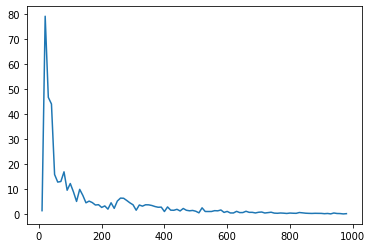

Epoch number 98
 Current loss 0.2538542151451111



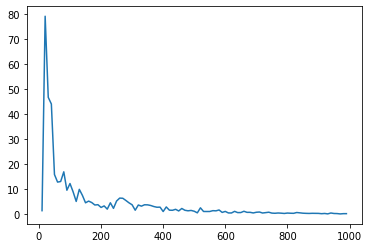

Epoch number 99
 Current loss 0.1859256774187088



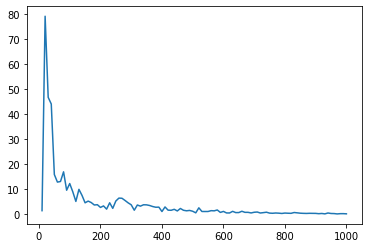

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Training the model
model = train()

In [21]:
torch.save(model.state_dict(), "/content/Project_Find_My_Dress/data/SiameseNet2.pt")
print("Model Saved Successfully")

Model Saved Successfully


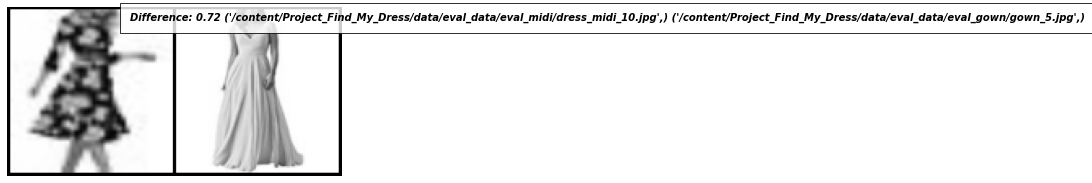

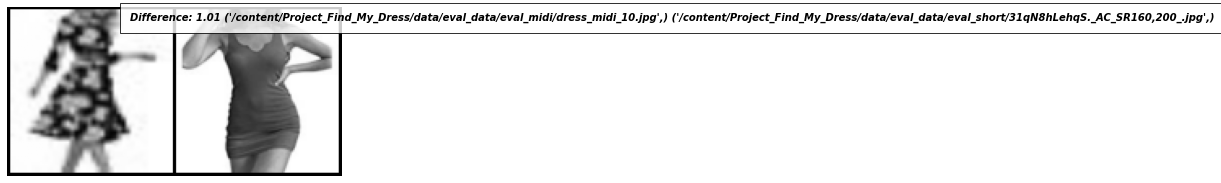

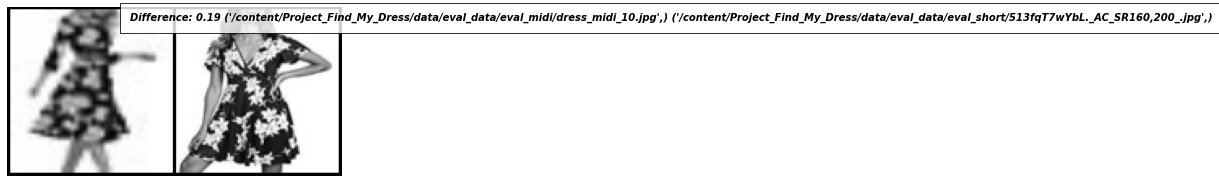

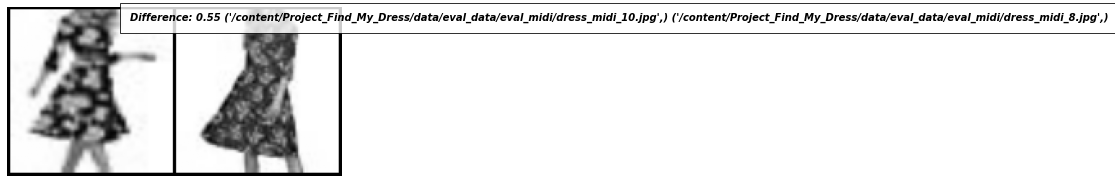

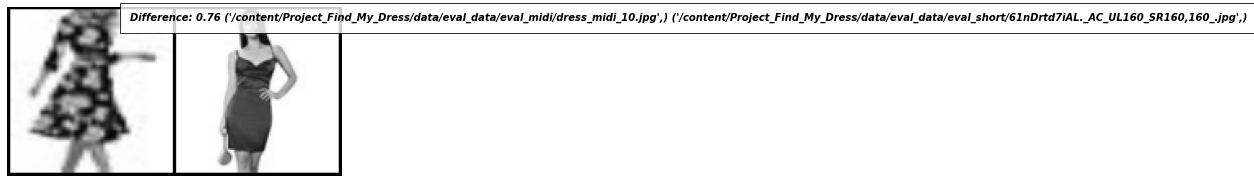

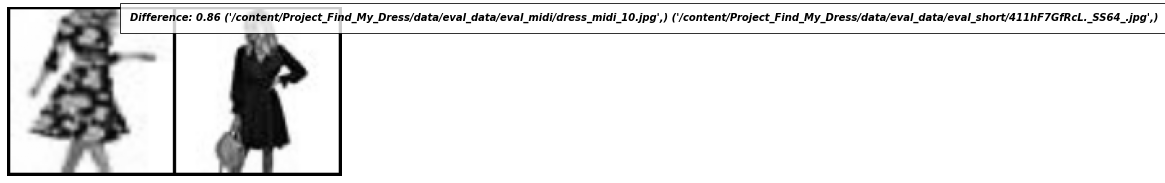

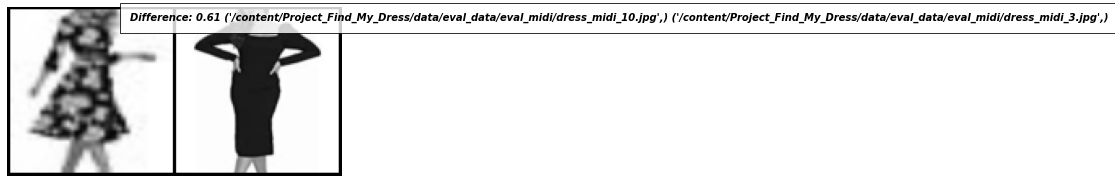

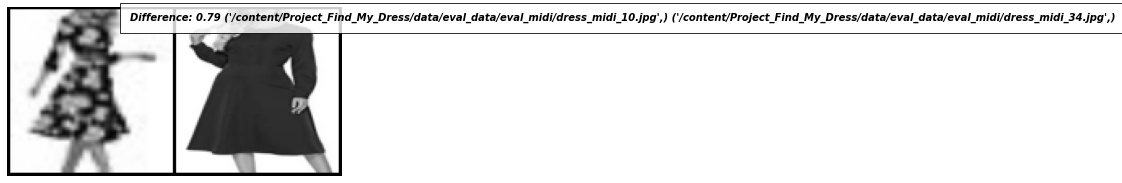

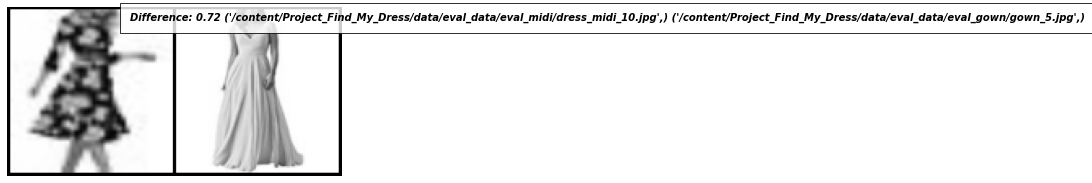

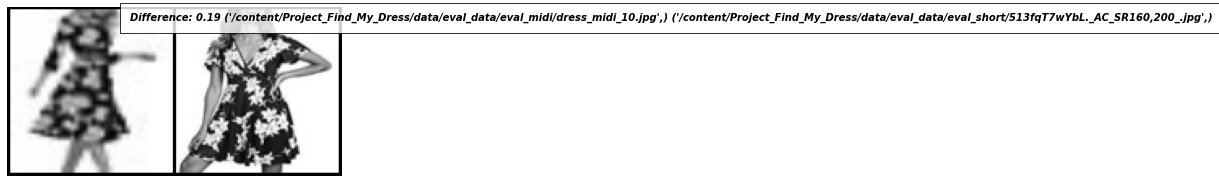

In [39]:
folder_dataset_test = dset.ImageFolder(root=Config.eval_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

test_dataloader = DataLoader(siamese_dataset,num_workers=6,batch_size=1,shuffle=True)
dataiter = iter(test_dataloader)
x0,_,_,label0,_ = next(dataiter)

x0.size()

for i in range(10):
    _,x1,label2,_,label1 = next(dataiter)
    concatenated = torch.cat((x0,x1),0)
    
    output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated),'Difference: {:.2f} {} {}'.format(euclidean_distance.item(), label0, label1))



In [23]:
files_anchor = get_image_files(Config.anchor_folder)
files_test = get_image_files(Config.test_folder)



Path('/content/Project_Find_My_Dress/data/test/short_6.jpg')

In [67]:
pairs_list = []

for i in range(len(files_test)):
   
    #print(label_func(files_test[i]))
    for k in range(len(files_anchor)):        
          pair = (files_anchor[i],files_test[k-i])
          pairs_list.append(pair)
          break
    

In [70]:

def euclidean_distance_image(fn0,fn1):
    "Open and load a `PIL.Image` and convert to `Tensor` and calculate euclidean distance"
    
    
    img0Test = Image.open(fn0)
    img1Test = Image.open(fn1)

    img0Test = img0Test.convert("L")
    img1Test = img1Test.convert("L")
    

    transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
    img0Test = transform(img0Test)

    img1Test = transform(img1Test)
   
     
    
    
    x0b = img0Test.unsqueeze(0)
 
    x1b = img1Test.unsqueeze(0)
    #print(x1b.size())
    concatenated = torch.cat((x0b,x1b),0)
    #print(x0b.shape)
    output1,output2 = net(Variable(x0b).cuda(),Variable(x1b).cuda())
    #print(output1)
    euclidean_distance = F.pairwise_distance(output1, output2)
    
    
    
    
    print('Difference: {:.2f}'.format(euclidean_distance.item()), fn0, fn1)
    
    return '{:.2f}'.format(euclidean_distance.item()), fn0, fn1
    


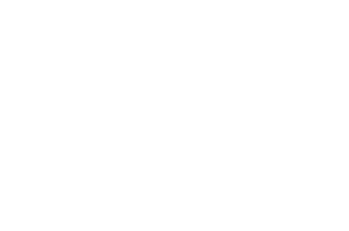

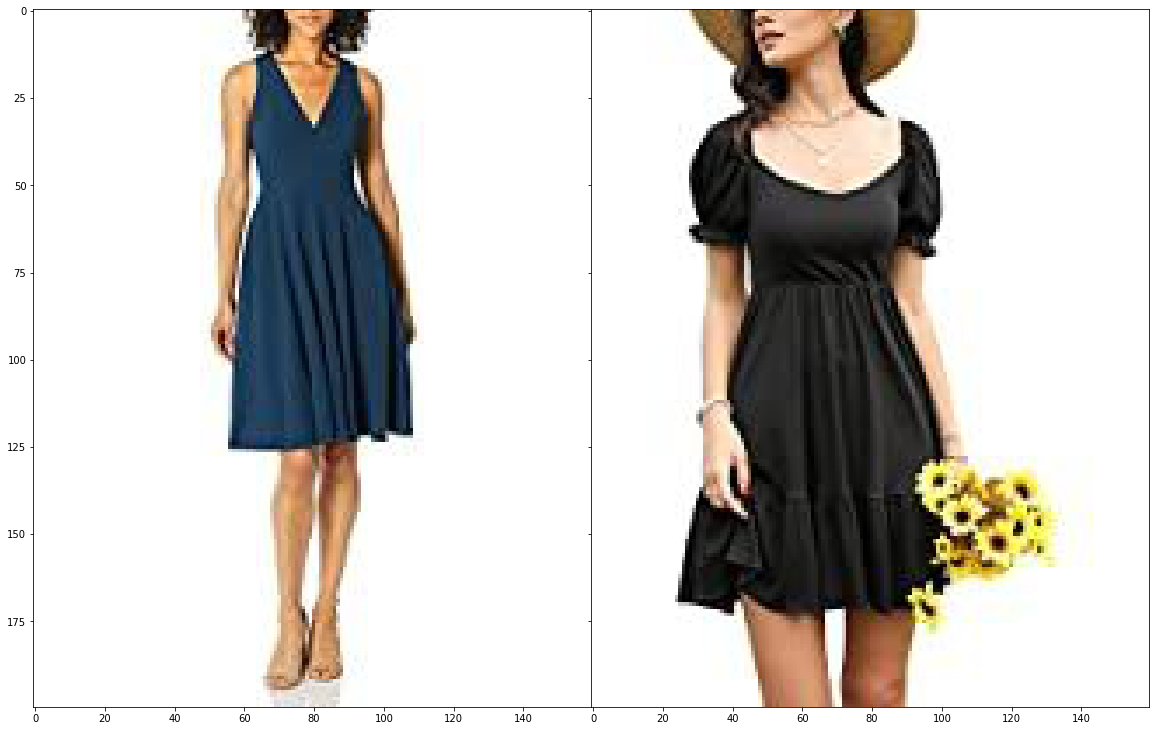

Difference: 0.39 /content/Project_Find_My_Dress/data/original/midi_5.jpg /content/Project_Find_My_Dress/data/test/short_4.jpg


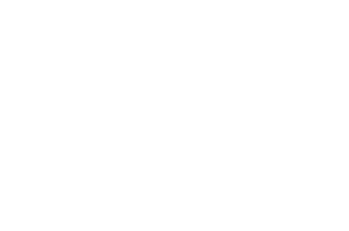

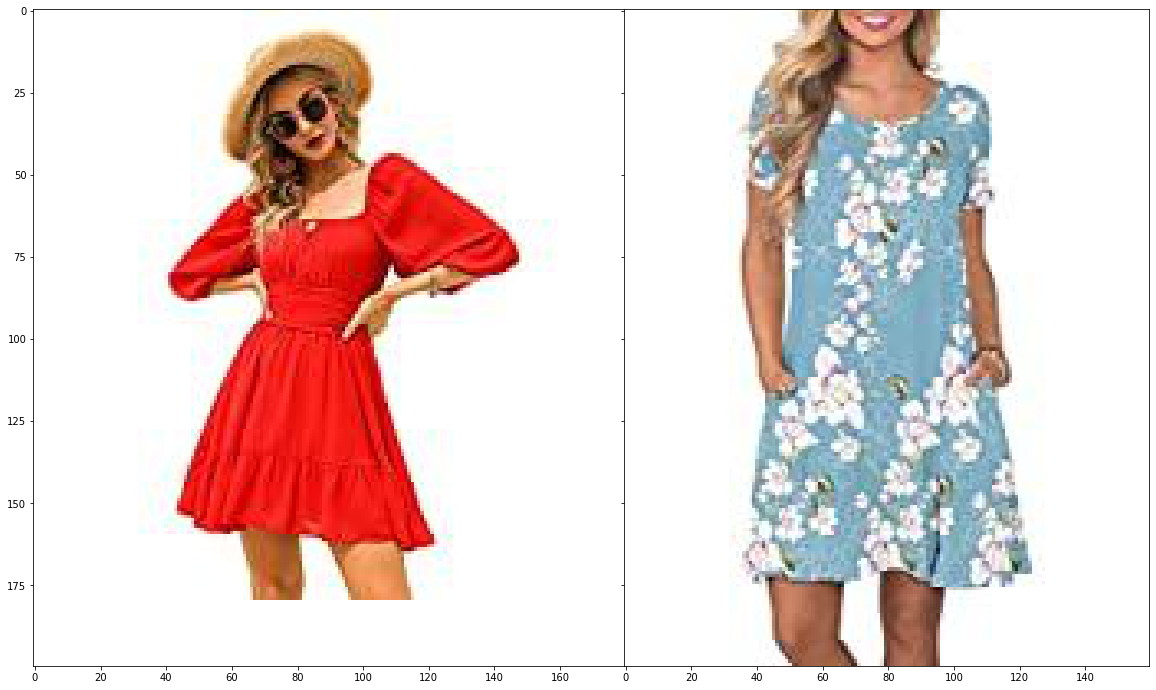

Difference: 0.47 /content/Project_Find_My_Dress/data/original/short_3.jpg /content/Project_Find_My_Dress/data/test/midi_14.jpg


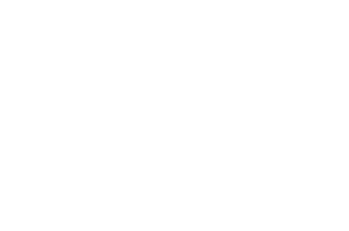

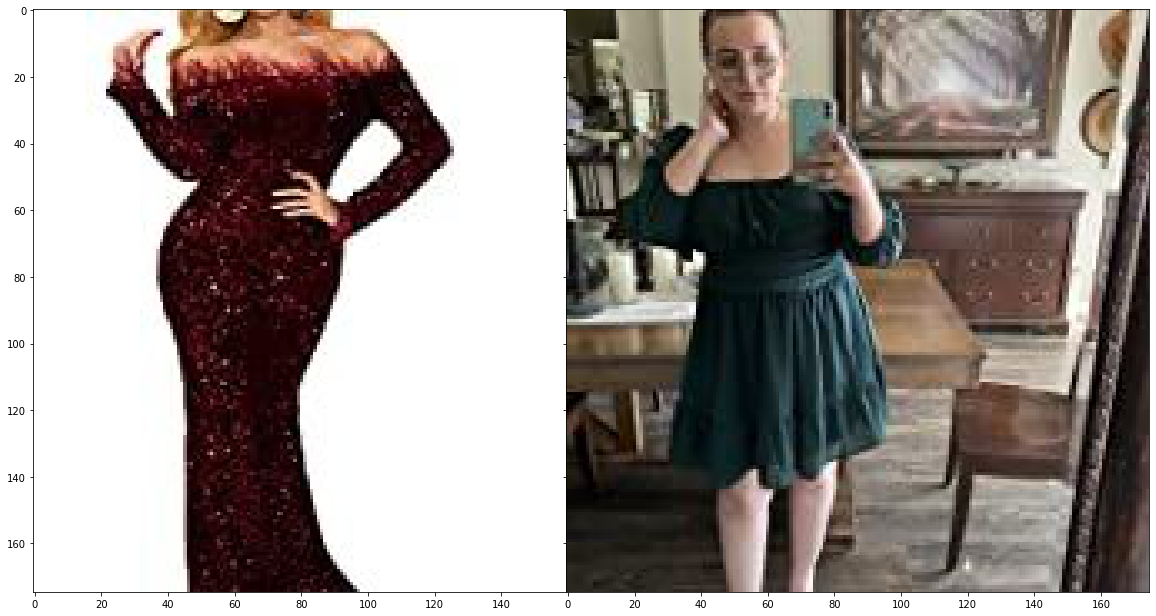

Difference: 0.79 /content/Project_Find_My_Dress/data/original/gown_2.jpg /content/Project_Find_My_Dress/data/test/short_77.jpg


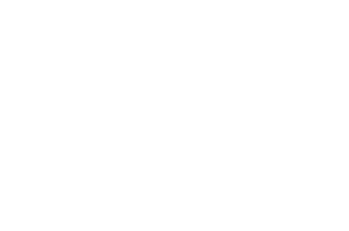

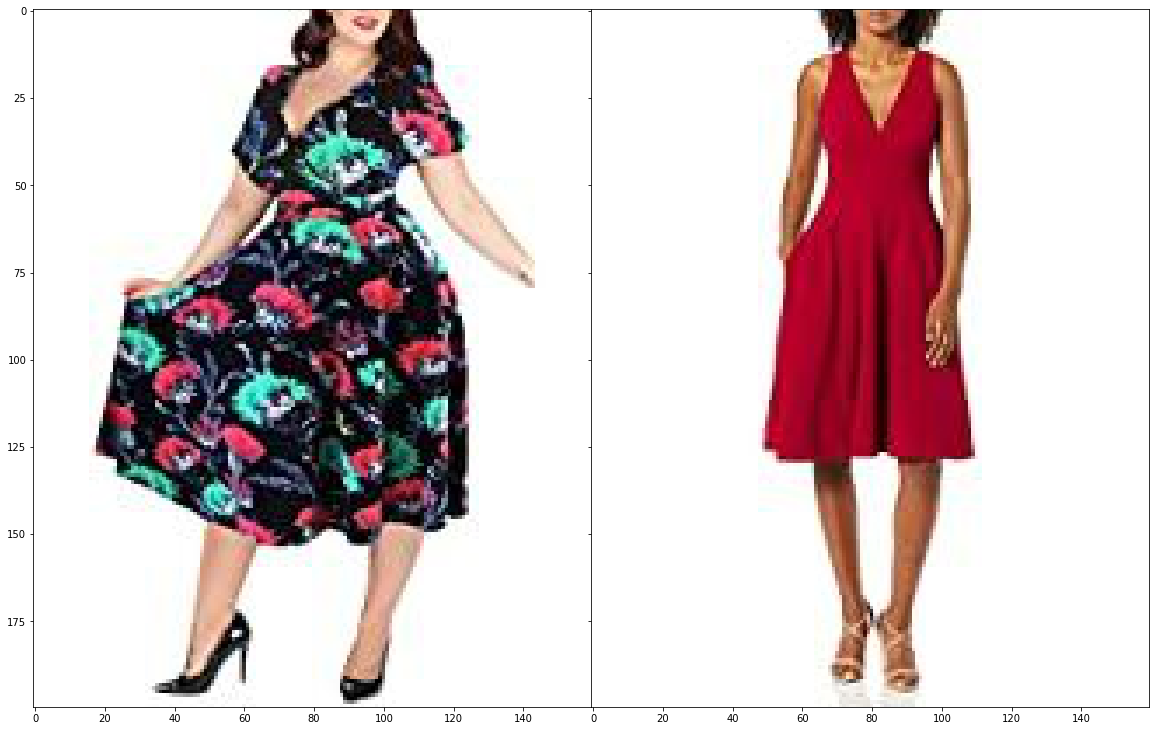

Difference: 0.20 /content/Project_Find_My_Dress/data/original/midi_21.jpg /content/Project_Find_My_Dress/data/test/midi_6.jpg


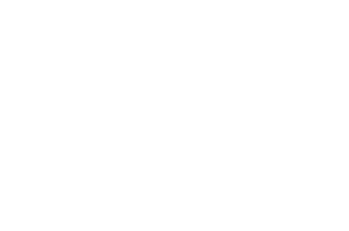

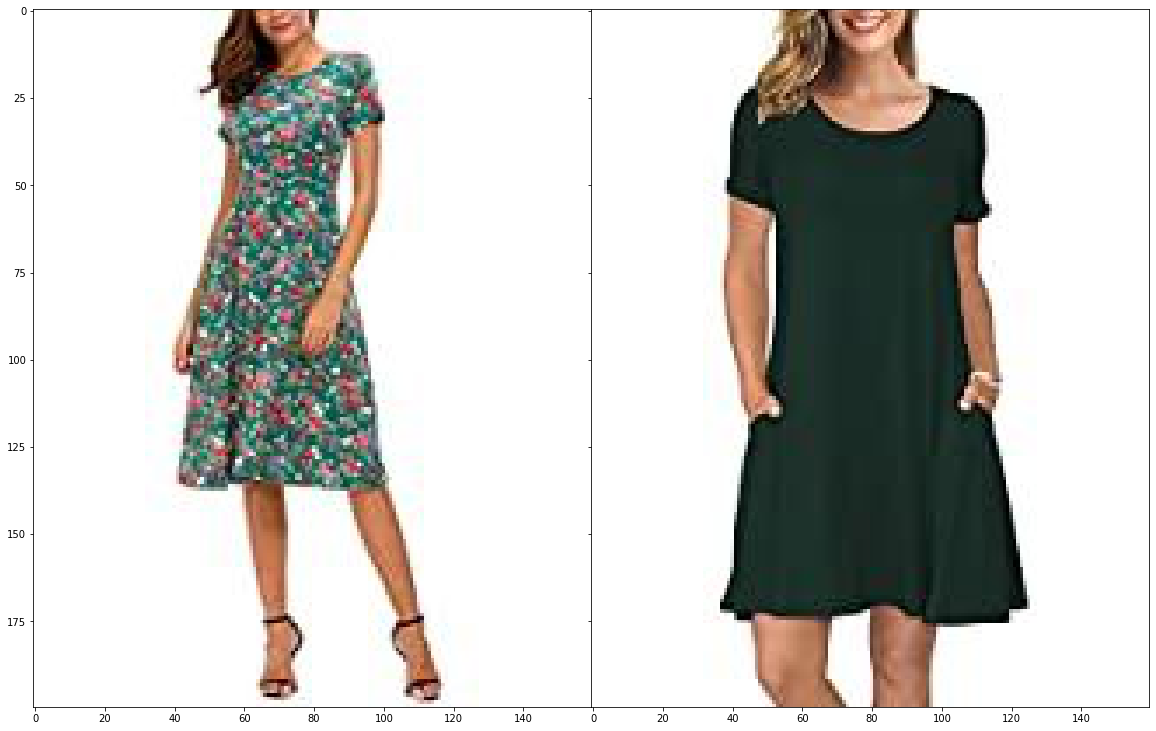

Difference: 0.85 /content/Project_Find_My_Dress/data/original/midi_13.jpg /content/Project_Find_My_Dress/data/test/midi_2.jpg


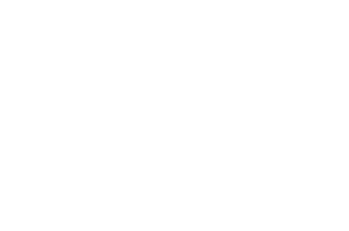

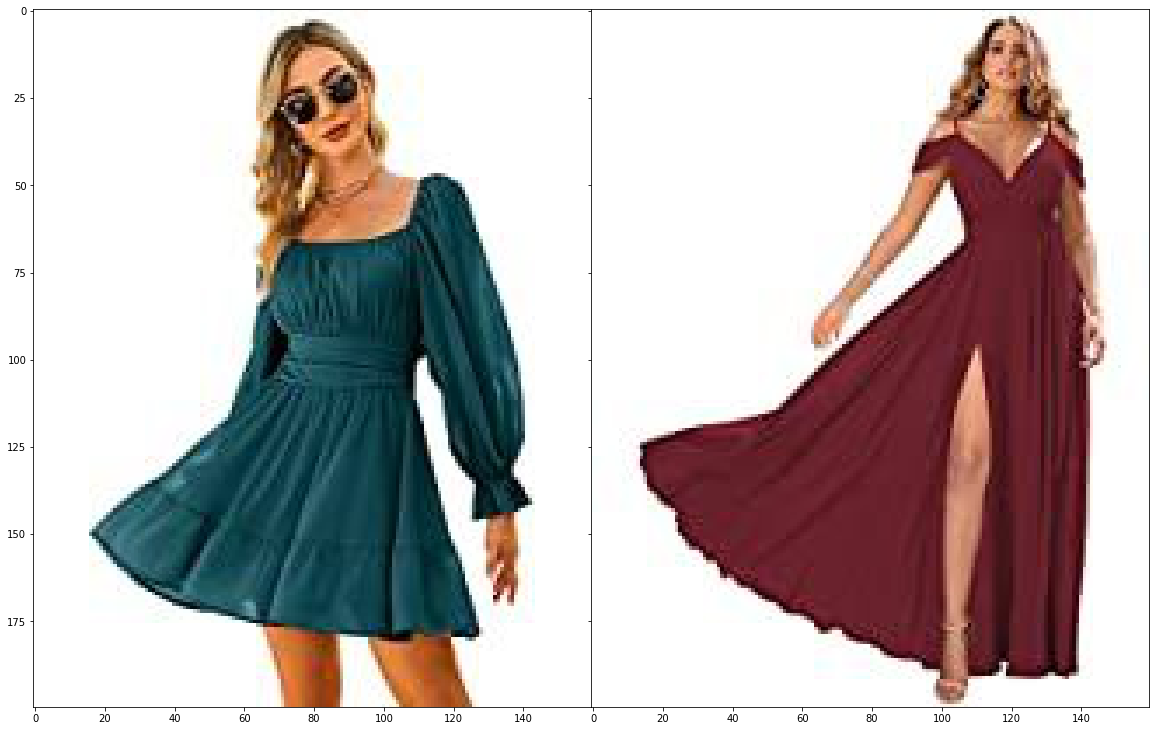

Difference: 0.47 /content/Project_Find_My_Dress/data/original/short_7.jpg /content/Project_Find_My_Dress/data/test/gown_5.jpg


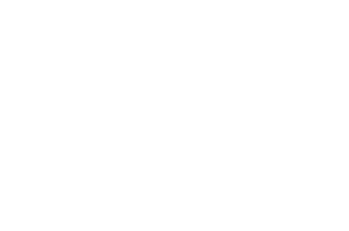

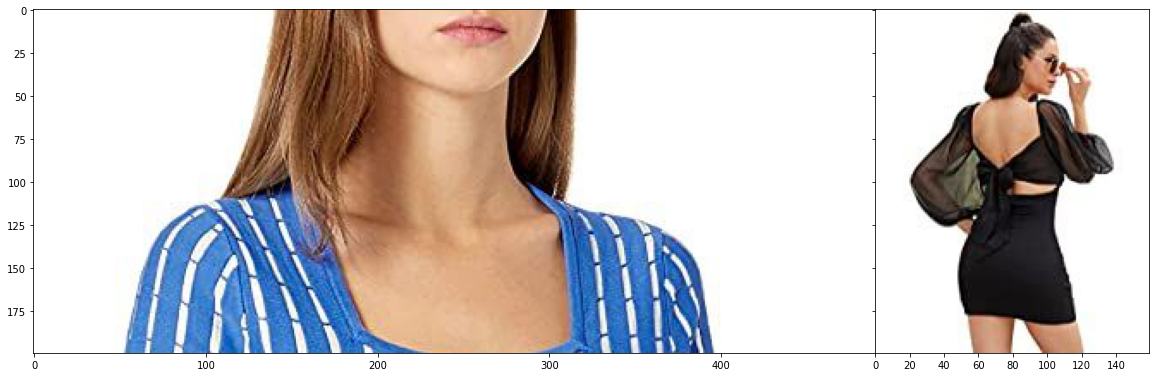

Difference: 0.58 /content/Project_Find_My_Dress/data/original/midi_19.jpg /content/Project_Find_My_Dress/data/test/short_1.jpg


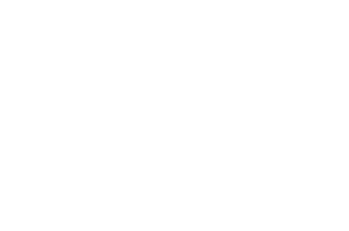

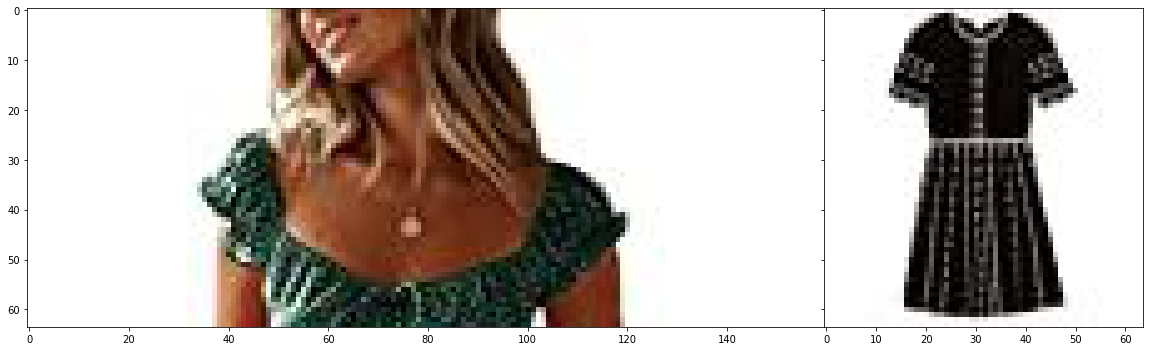

Difference: 0.37 /content/Project_Find_My_Dress/data/original/short_5.jpg /content/Project_Find_My_Dress/data/test/4122emOhsqL._SS64_.jpg


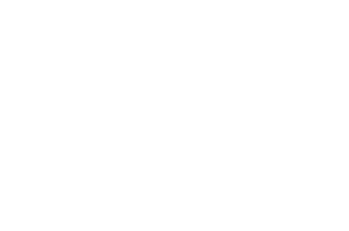

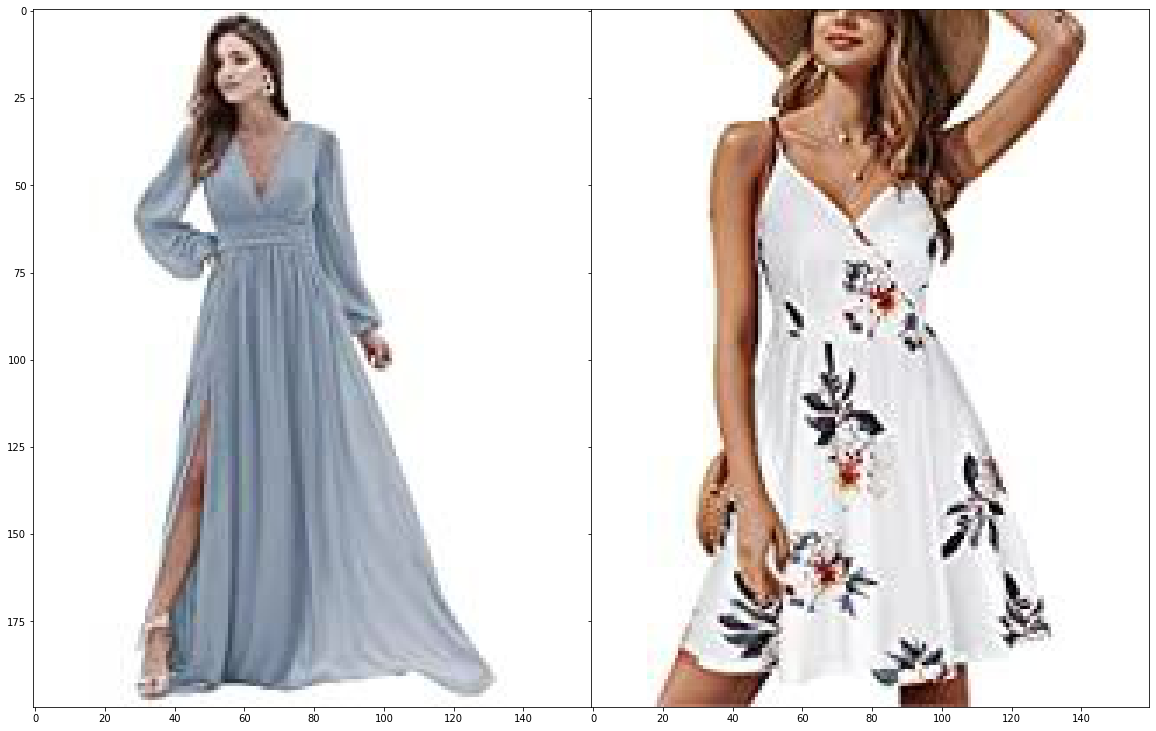

Difference: 0.52 /content/Project_Find_My_Dress/data/original/gown_4.jpg /content/Project_Find_My_Dress/data/test/midi_12.jpg


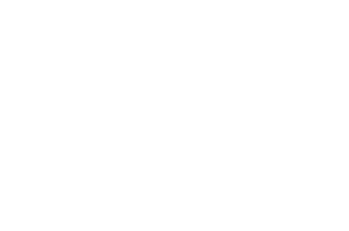

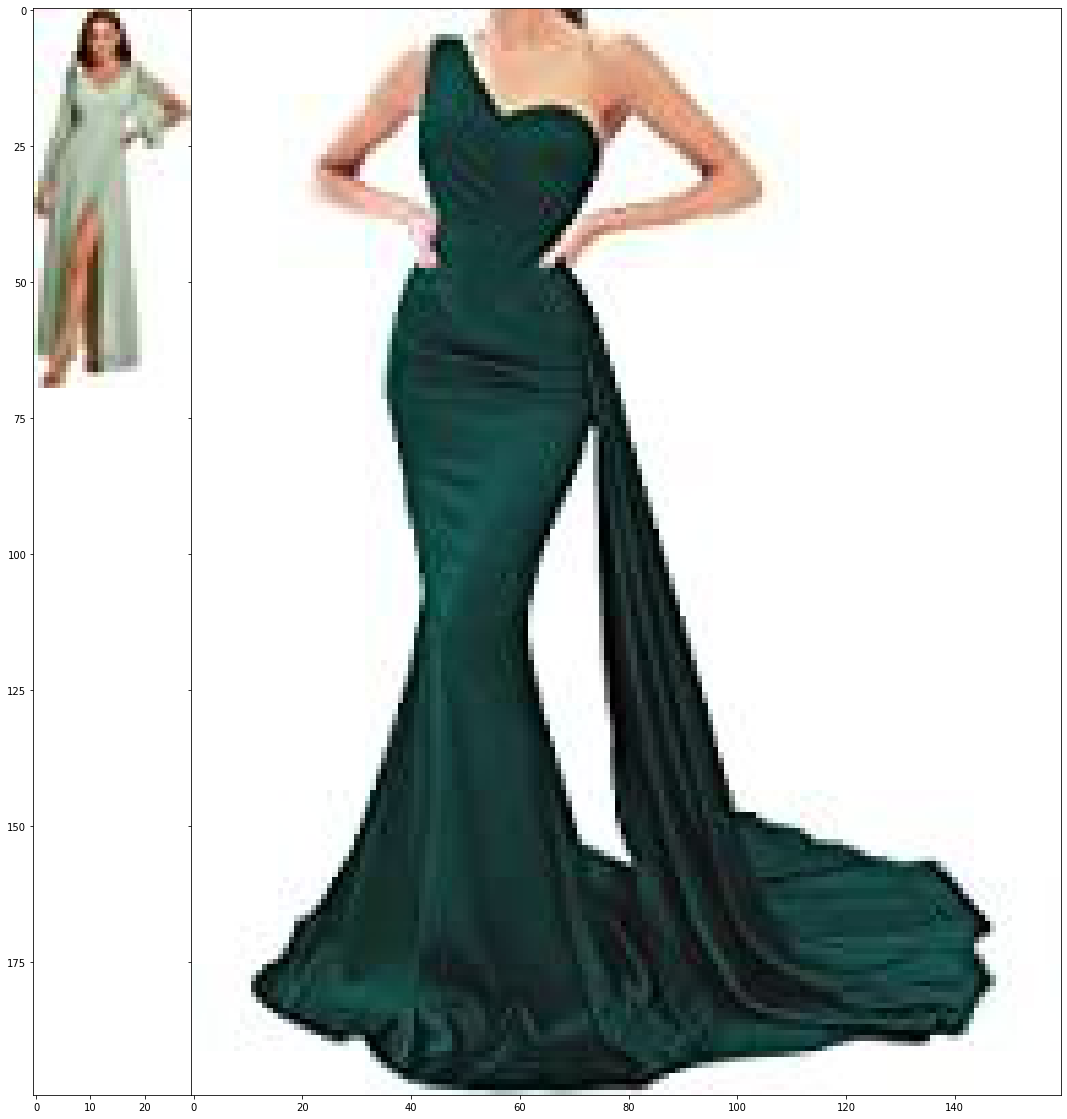

Difference: 1.08 /content/Project_Find_My_Dress/data/original/gown_8.jpg /content/Project_Find_My_Dress/data/test/gown_6.jpg


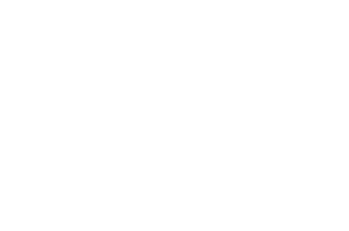

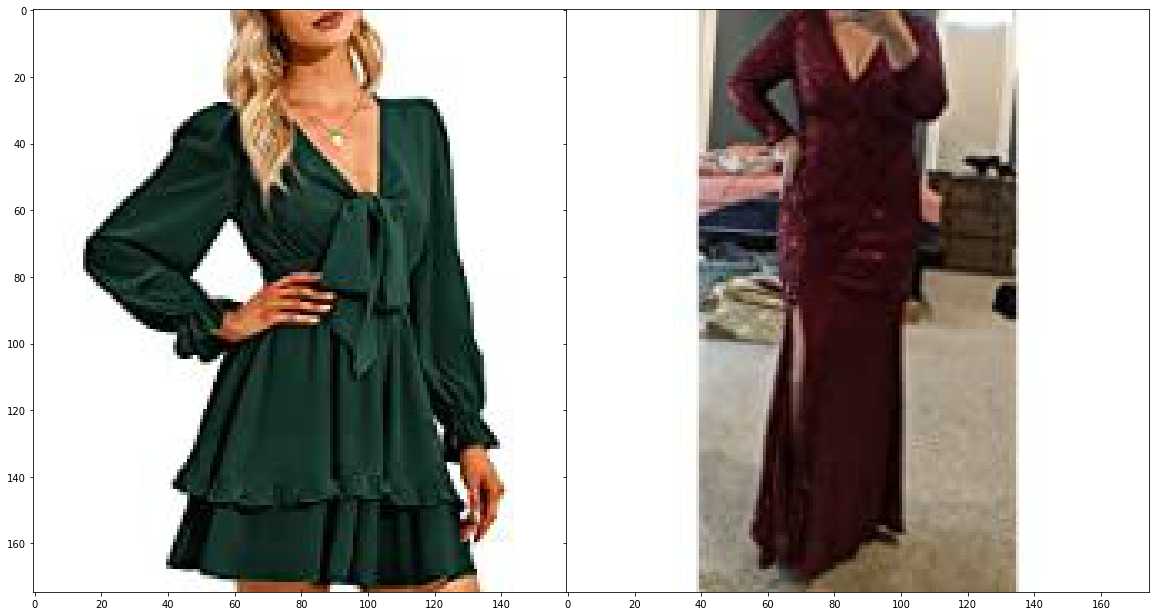

Difference: 0.45 /content/Project_Find_My_Dress/data/original/short_2.jpg /content/Project_Find_My_Dress/data/test/gown3.jpg


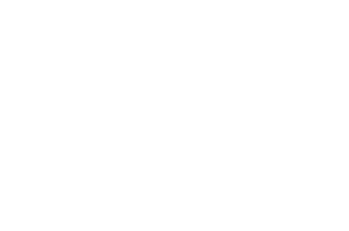

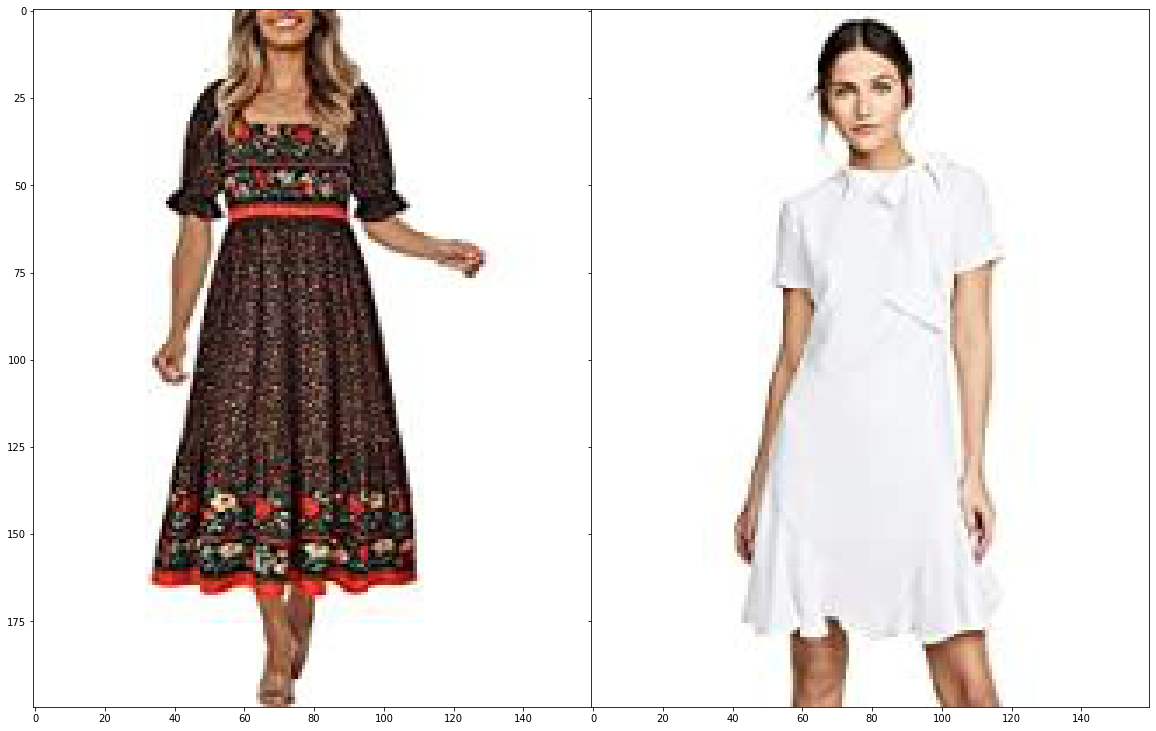

Difference: 0.95 /content/Project_Find_My_Dress/data/original/midi_17.jpg /content/Project_Find_My_Dress/data/test/midi_1.jpg


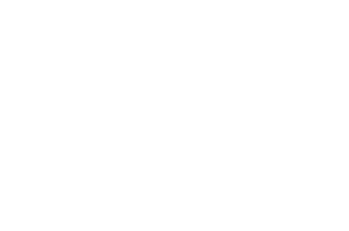

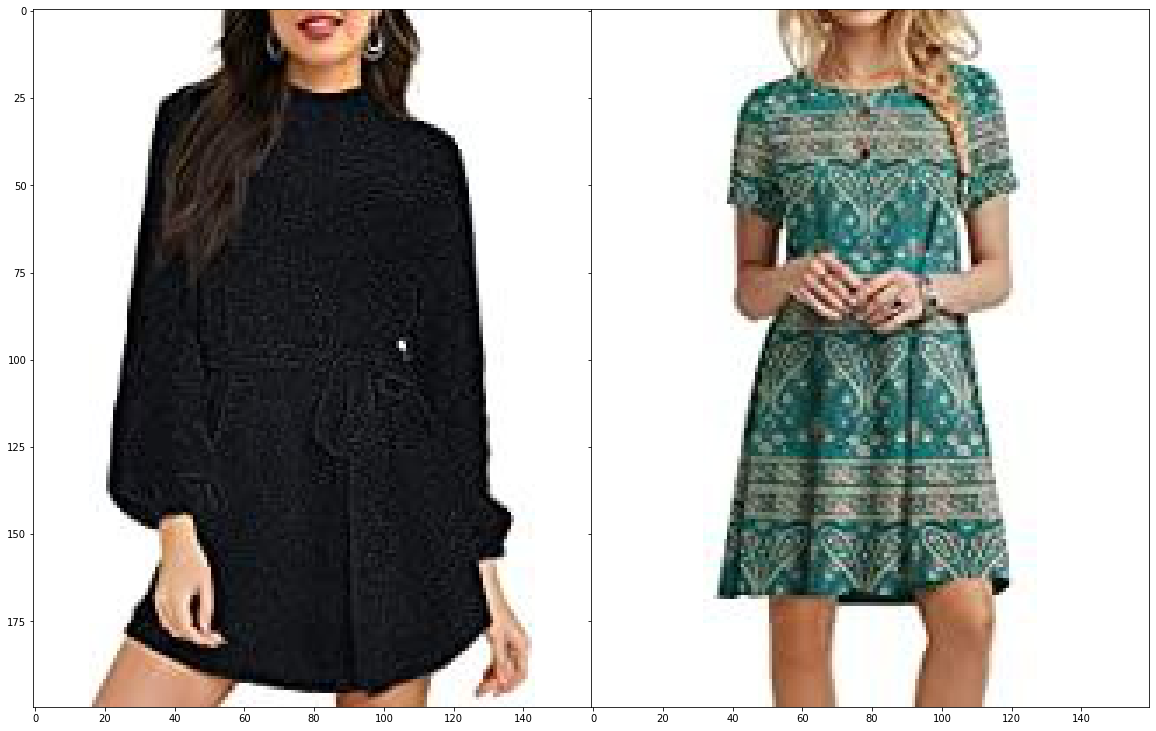

Difference: 0.72 /content/Project_Find_My_Dress/data/original/midi_11.jpg /content/Project_Find_My_Dress/data/test/midi_18.jpg


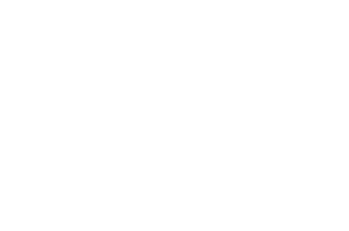

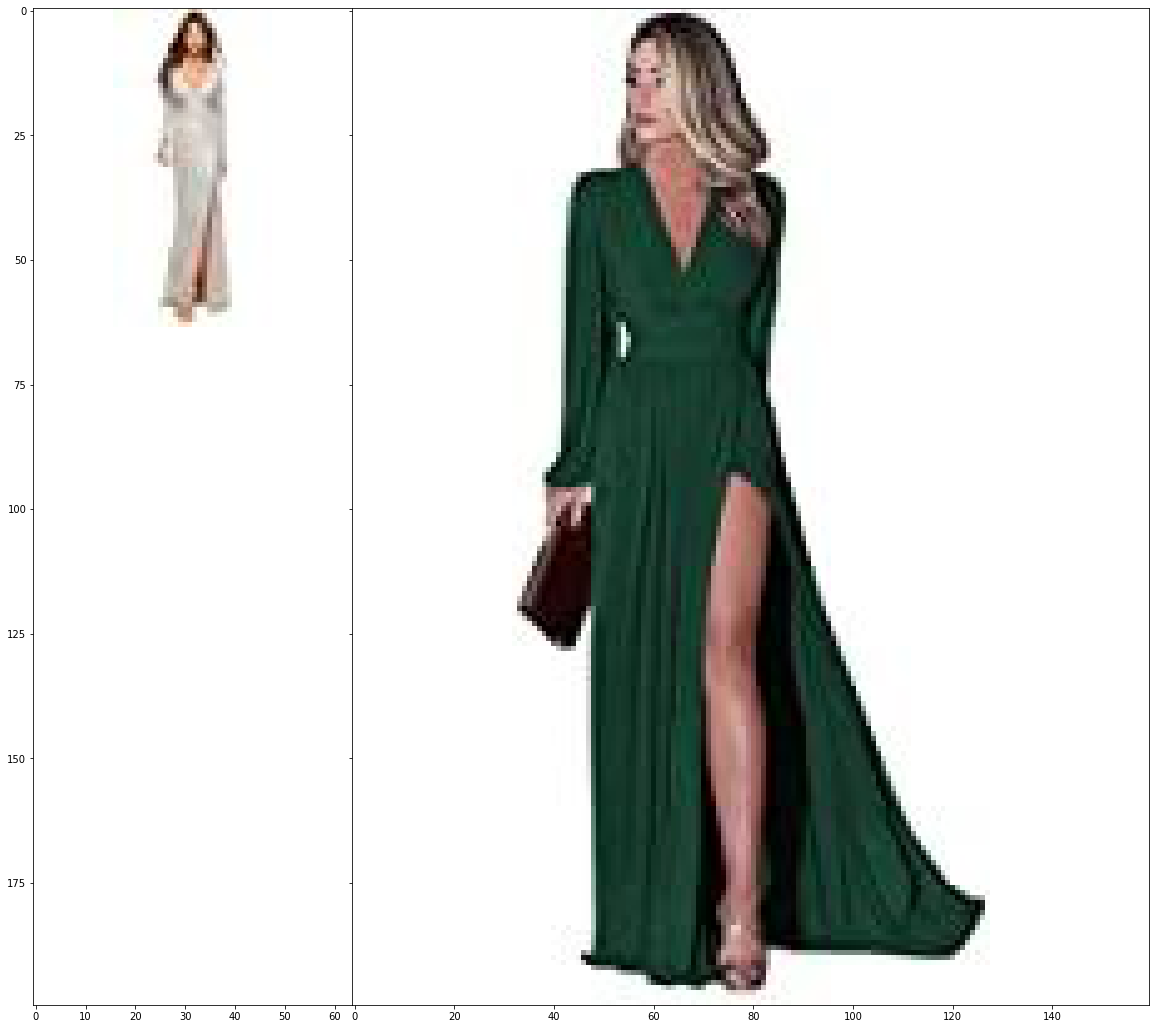

Difference: 0.55 /content/Project_Find_My_Dress/data/original/gown_7.jpg /content/Project_Find_My_Dress/data/test/gown_1.jpg


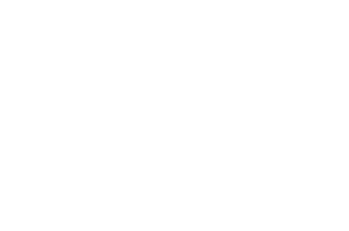

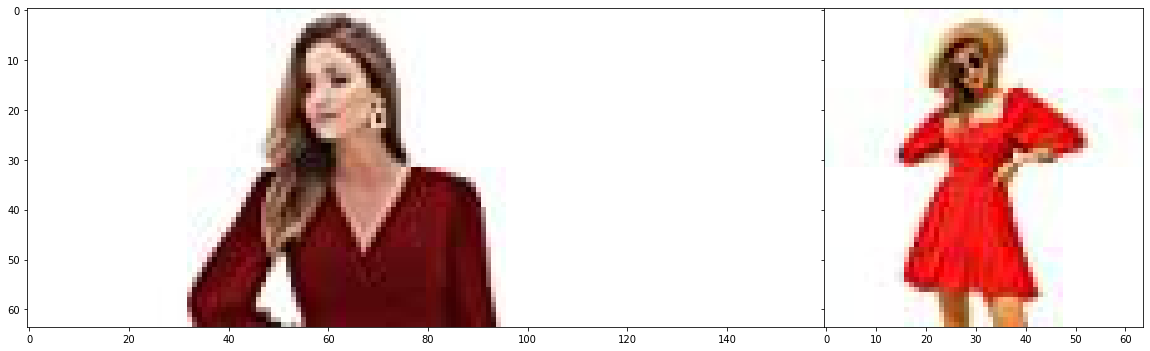

Difference: 0.29 /content/Project_Find_My_Dress/data/original/gown_1.jpg /content/Project_Find_My_Dress/data/test/short_33.jpg


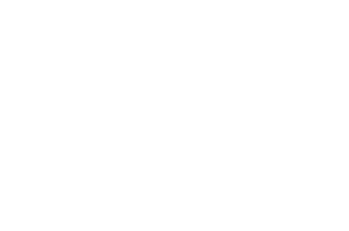

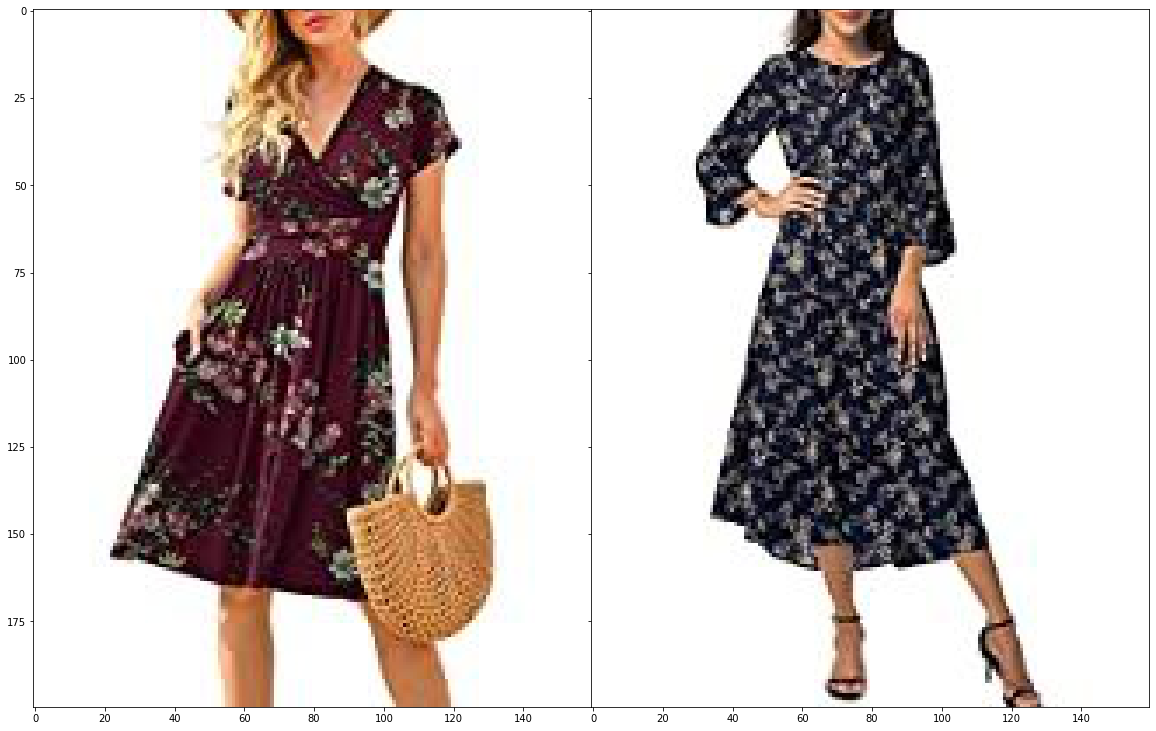

Difference: 0.77 /content/Project_Find_My_Dress/data/original/midi_7.jpg /content/Project_Find_My_Dress/data/test/midi_8.jpg


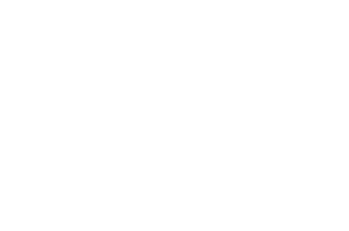

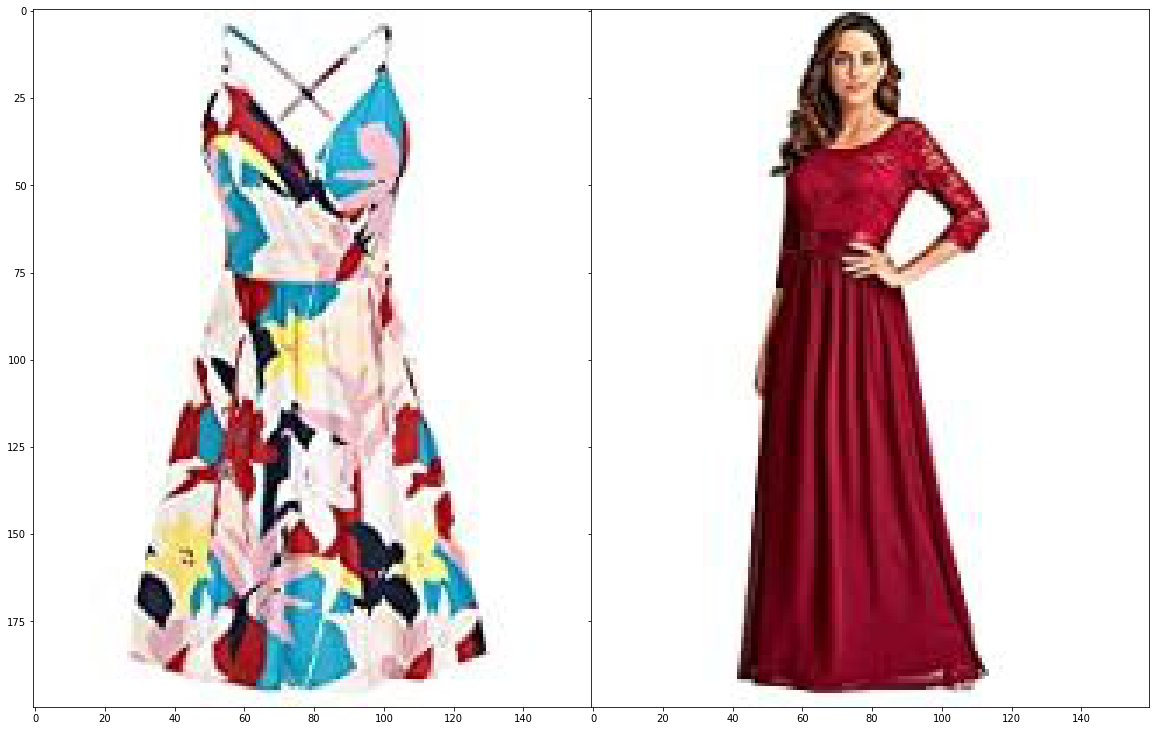

Difference: 0.81 /content/Project_Find_My_Dress/data/original/midi_9.jpg /content/Project_Find_My_Dress/data/test/gown_7.jpg


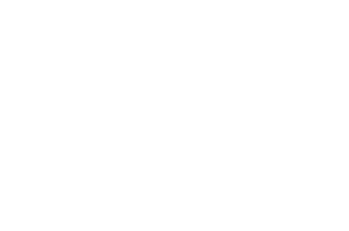

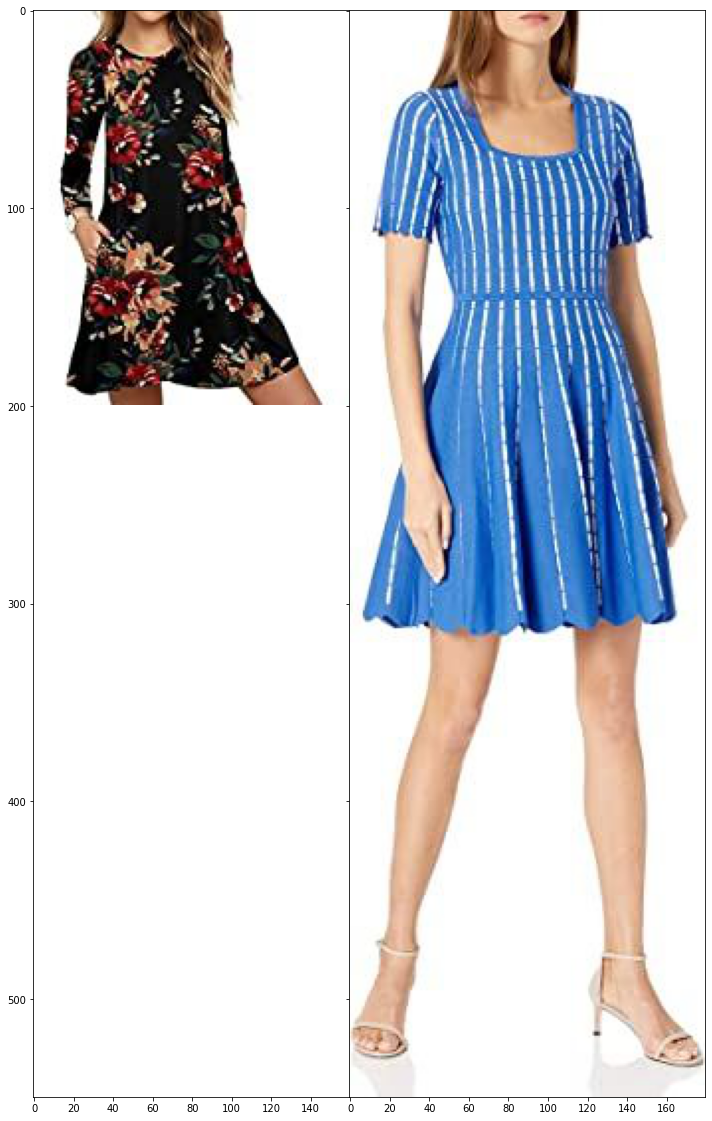

Difference: 0.68 /content/Project_Find_My_Dress/data/original/short_10.jpg /content/Project_Find_My_Dress/data/test/midi_20.jpg


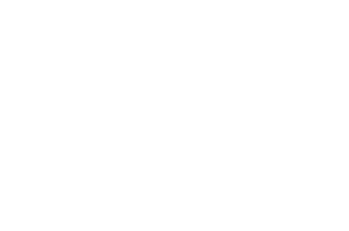

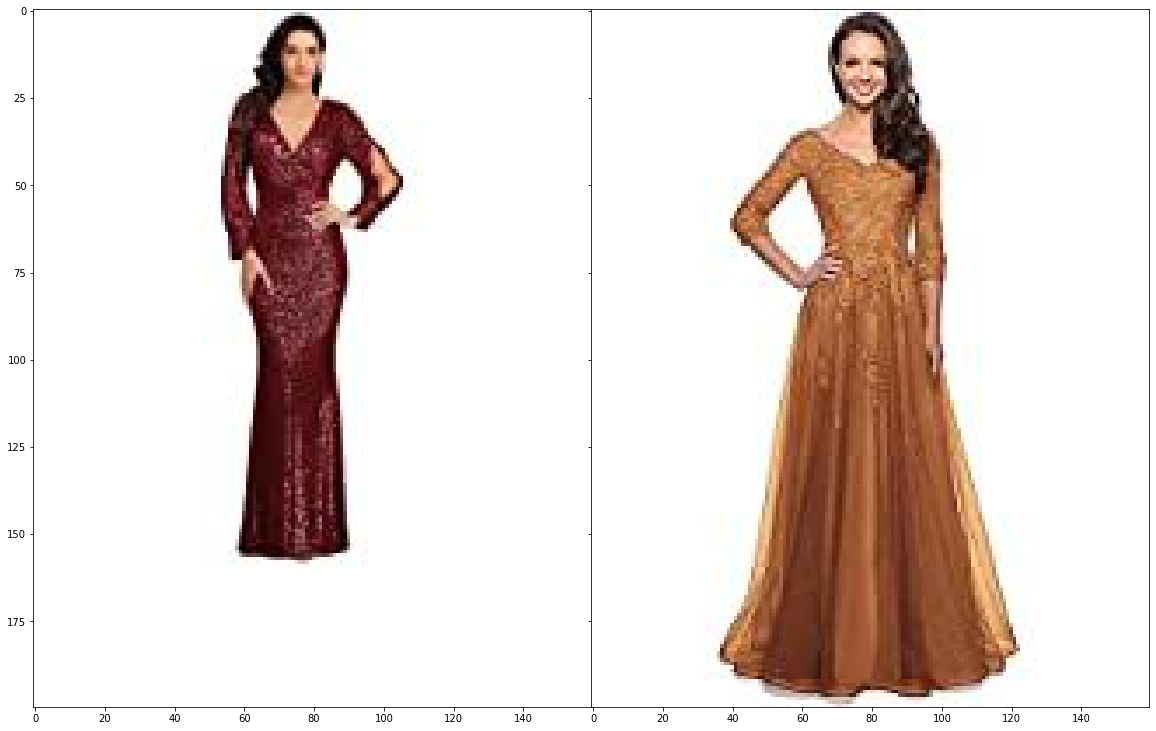

Difference: 0.37 /content/Project_Find_My_Dress/data/original/gown3.jpg /content/Project_Find_My_Dress/data/test/gown_8.jpg


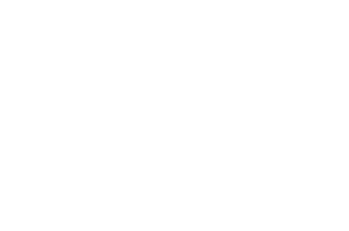

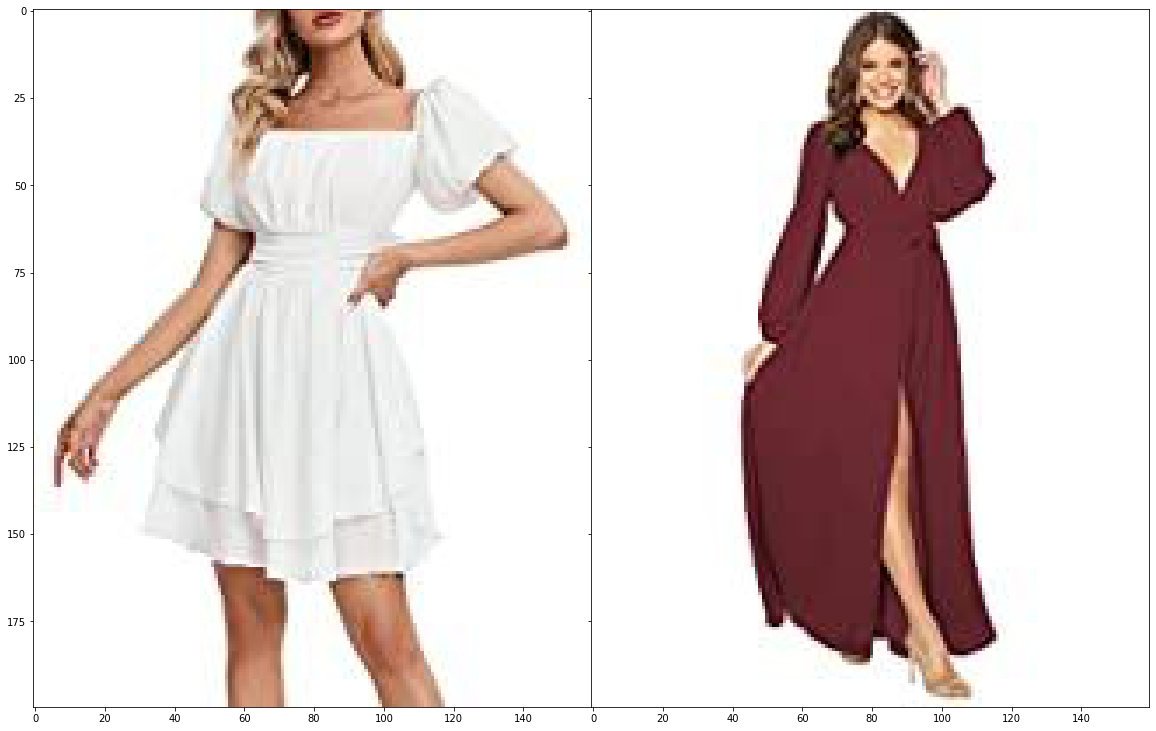

Difference: 0.31 /content/Project_Find_My_Dress/data/original/short_11.jpg /content/Project_Find_My_Dress/data/test/gown_4.jpg


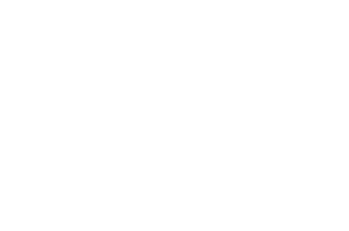

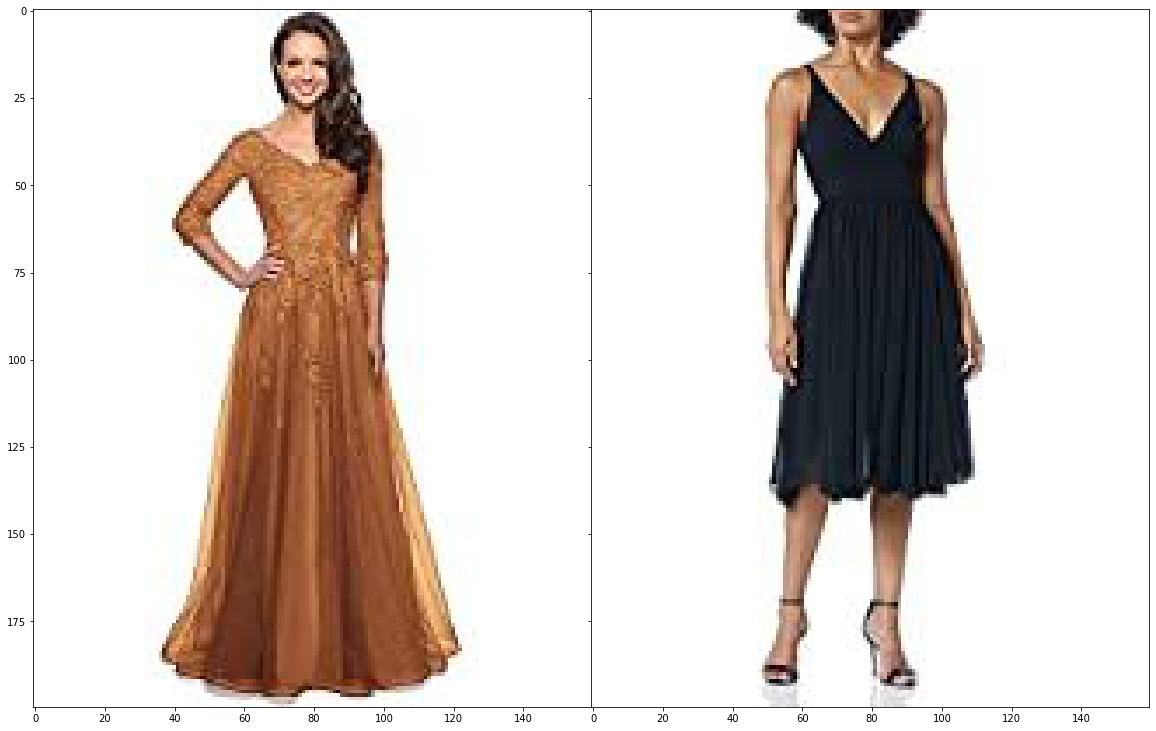

Difference: 0.62 /content/Project_Find_My_Dress/data/original/gown_6.jpg /content/Project_Find_My_Dress/data/test/midi_3.jpg


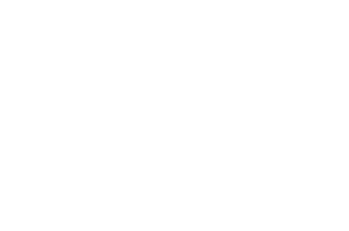

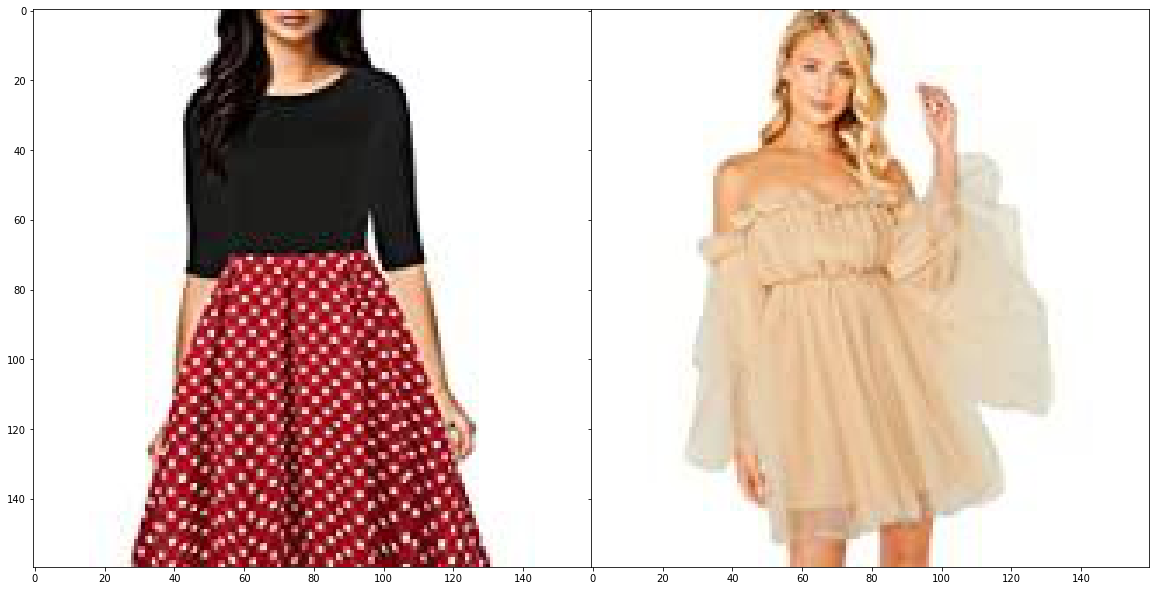

Difference: 0.35 /content/Project_Find_My_Dress/data/original/midi_16.jpg /content/Project_Find_My_Dress/data/test/short_8.jpg


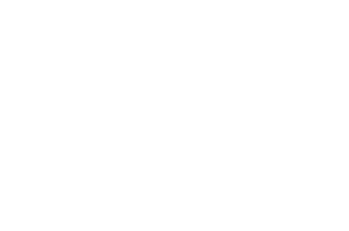

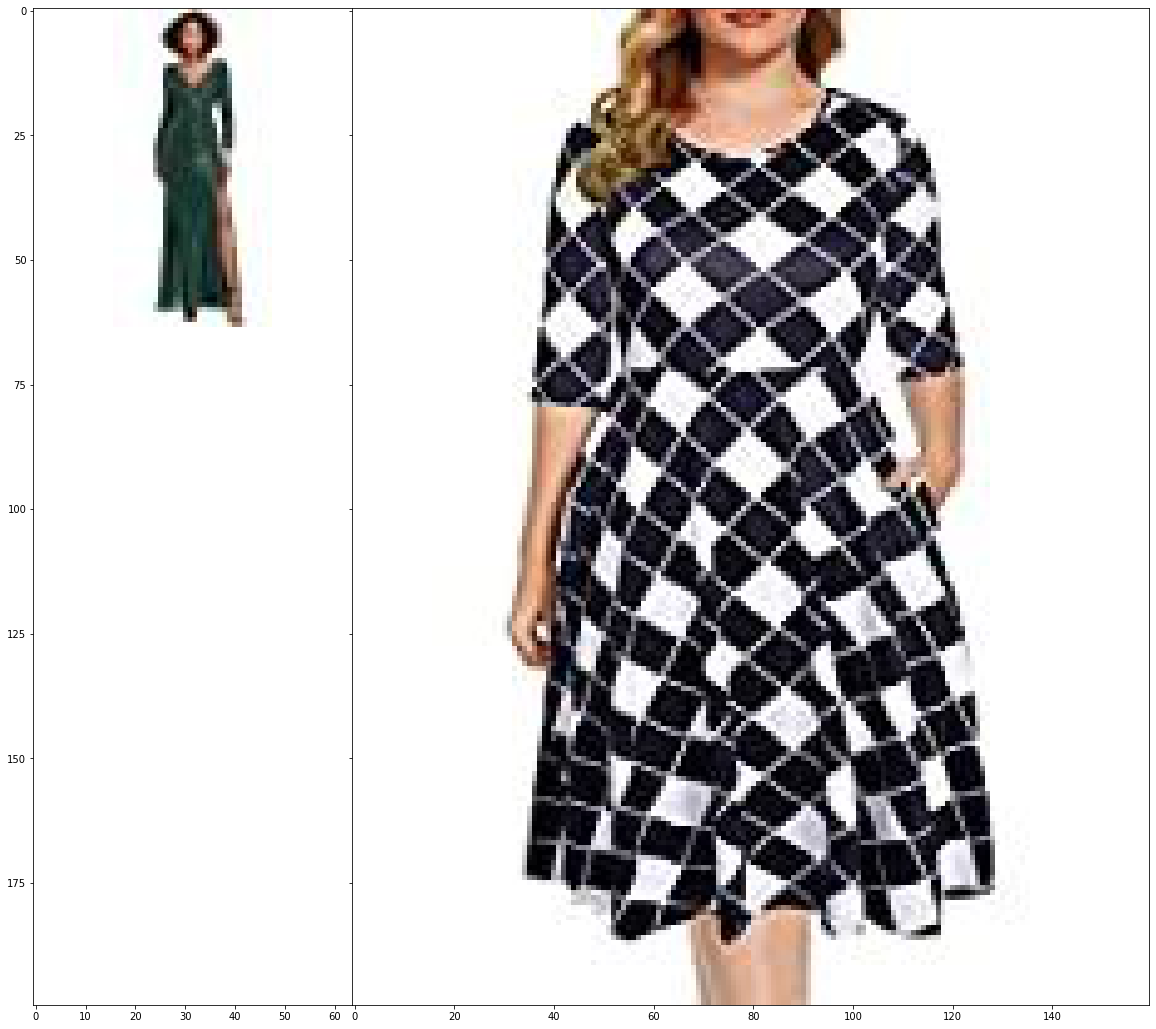

Difference: 1.52 /content/Project_Find_My_Dress/data/original/gown_5.jpg /content/Project_Find_My_Dress/data/test/midi_22.jpg


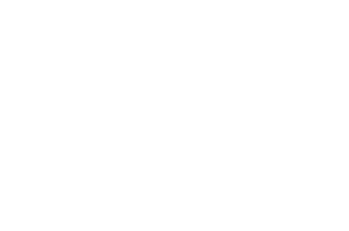

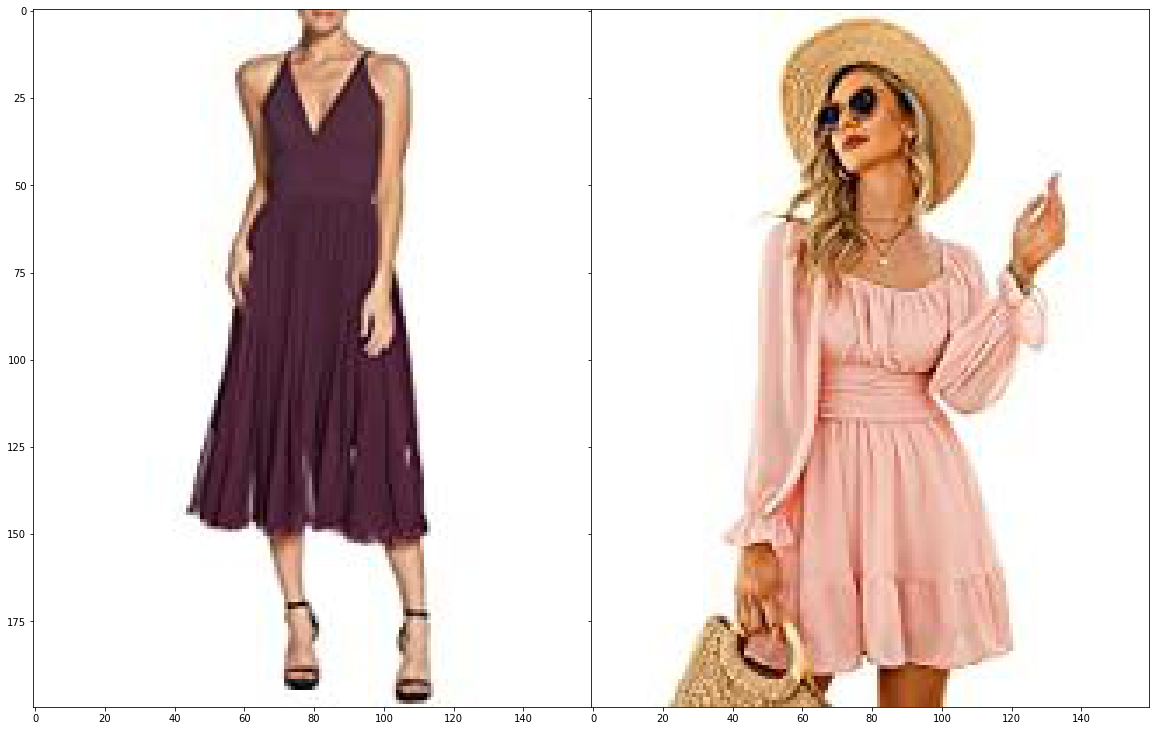

Difference: 0.48 /content/Project_Find_My_Dress/data/original/midi_4.jpg /content/Project_Find_My_Dress/data/test/short_6.jpg


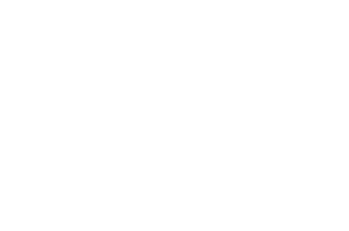

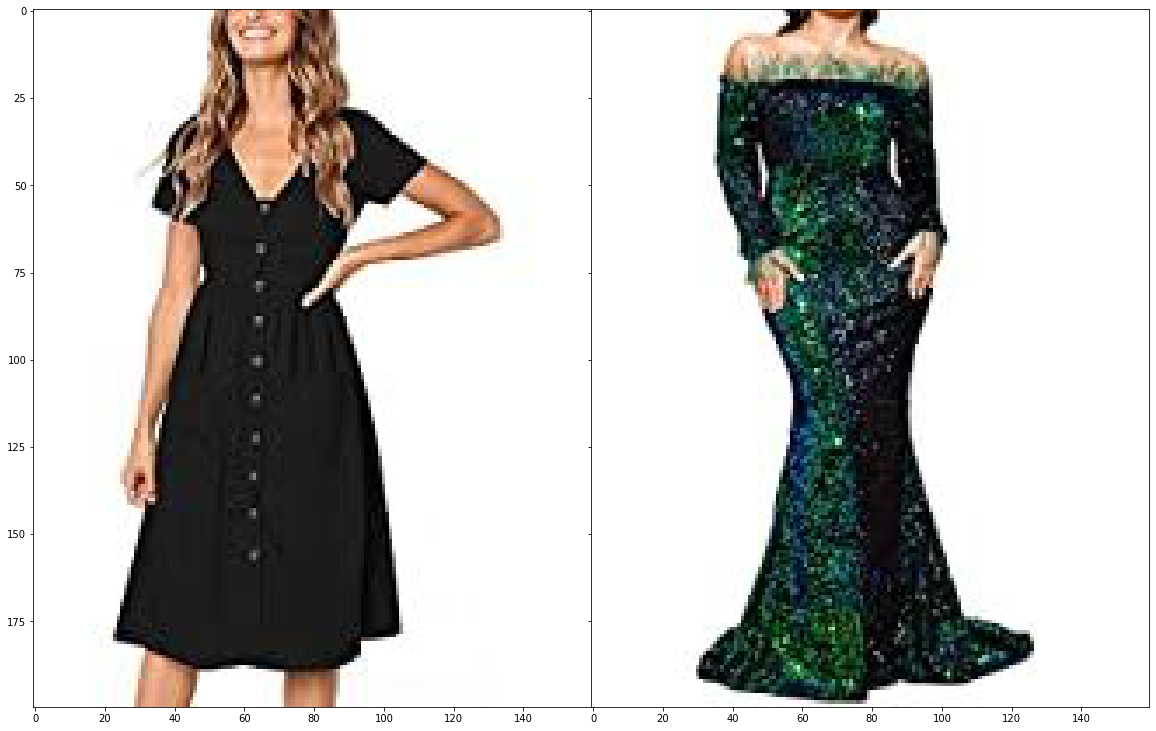

Difference: 0.61 /content/Project_Find_My_Dress/data/original/midi_15.jpg /content/Project_Find_My_Dress/data/test/gown_2.jpg


In [71]:
for index, mytuple in enumerate(pairs_list):
    element_one = mytuple[0]
    element_two = mytuple[1]    
    rgb_display(mytuple[0], mytuple[1])
    euclidean_distance_image(element_one, element_two)

In [63]:

mini_red = "/content/Project_Find_My_Dress/data/original/short_3.jpg"
mini_red_same = "/content/Project_Find_My_Dress/data/test/short_33.jpg"
mini_pink_same = "/content/Project_Find_My_Dress/data/test/short_6.jpg"


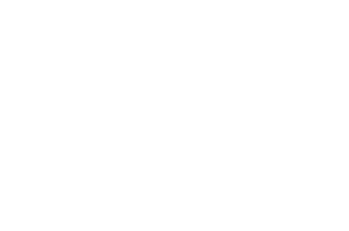

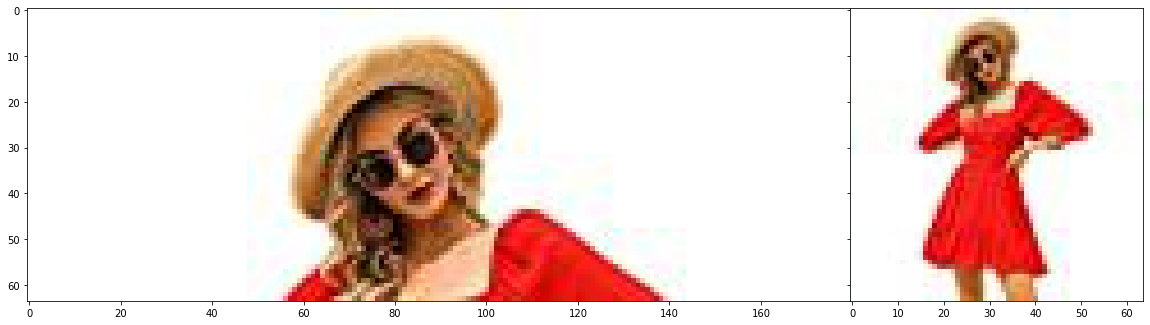

Difference: 0.05 /content/Project_Find_My_Dress/data/original/short_3.jpg /content/Project_Find_My_Dress/data/test/short_33.jpg


('0.05',
 '/content/Project_Find_My_Dress/data/original/short_3.jpg',
 '/content/Project_Find_My_Dress/data/test/short_33.jpg')

In [64]:
rgb_display(mini_red, mini_red_same)
euclidean_distance_image(mini_red, mini_red_same)

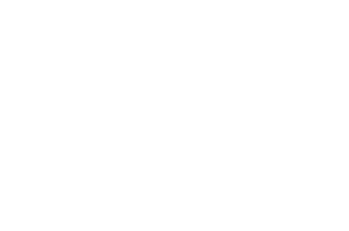

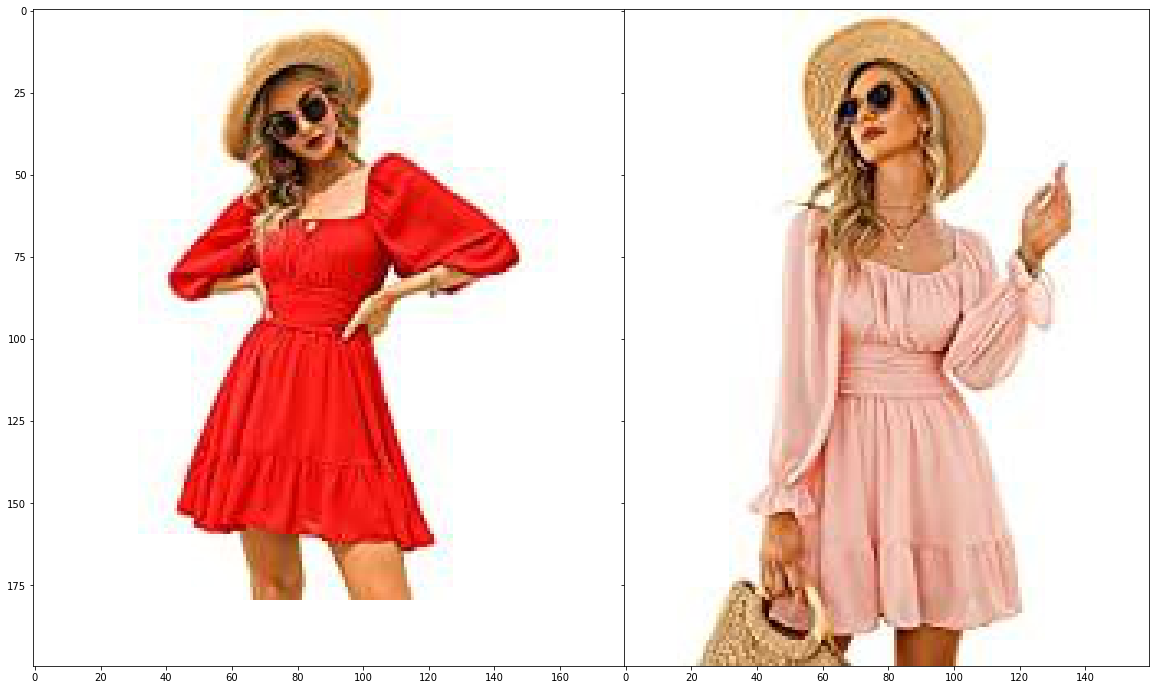

Difference: 0.23 /content/Project_Find_My_Dress/data/original/short_3.jpg /content/Project_Find_My_Dress/data/test/short_6.jpg


('0.23',
 '/content/Project_Find_My_Dress/data/original/short_3.jpg',
 '/content/Project_Find_My_Dress/data/test/short_6.jpg')

In [65]:
rgb_display(mini_red, mini_pink_same)
euclidean_distance_image(mini_red, mini_pink_same)